In [1]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

In [293]:

def make_datasets(n_obs=10, degree=2, clusters=3, T=15, n_samples=100, repetitions=False):
    clusters_reps = [nx.random_regular_graph(d=degree, n=n_obs) for i in range(clusters)]
    adjacencies = []
    for i in range(clusters):
        A = nx.adjacency_matrix(clusters_reps[i]).todense().astype(float)
        A[np.where(A!=0)]= np.random.rand(np.where(A!=0)[0].size)*0.45
        np.fill_diagonal(A, 1)
        adjacencies.append(A)
    
    pos = np.arange(0, T, T//(clusters+1))
    pos = np.sort(pos)
    pos = list(pos)+[T-1]
    
    thetas = []
    for i in range(len(pos)-1):
        how_many = int(pos[i+1]) - int(pos[i])-1
        new_list = [adjacencies[i%clusters]]
        target = adjacencies[(i+1)%clusters]

        for i in range(how_many):

            new = new_list[-1].copy()
            diffs = (new!=0).astype(int)-(target!=0).astype(int)
            diff = np.where(diffs!=0)
            if diff == ():
                break
            if(i==0):
                edges_per_change = int((np.nonzero(diffs)[0].shape[0]/2)//(how_many+1))
                if edges_per_change ==0:
                    edges_per_change+=1
            ixs = np.arange(diff[0].shape[0])
            np.random.shuffle(ixs)

            xs = diff[0][ixs[:edges_per_change]]
            ys = diff[1][ixs[:edges_per_change]]
            for j in range(xs.shape[0]):
                if diffs[xs[j], ys[j]] == -1:
                    new[xs[j], ys[j]] = np.random.rand(1)*0.2
                    new[ ys[j], xs[j]]=  new[xs[j], ys[j]]
                else:
                    new[xs[j], ys[j]] = 0
                    new[ ys[j], xs[j]]=0
            new_list.append(new)

        thetas += new_list
    thetas.append(target)
    covs = [np.linalg.inv(t) for t in thetas]
    samples = [np.random.multivariate_normal(np.zeros(n_obs), c, size=n_samples) for c in covs]
    return thetas, samples, covs, clusters_reps, pos

In [294]:
thetas, samples, covs, clusters_reps, pos= make_datasets(n_obs=10, degree=2, clusters=3, T=15, repetitions=False)

/home/vero/miniconda2/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:49: RuntimeWarning: covariance is not positive-semidefinite.


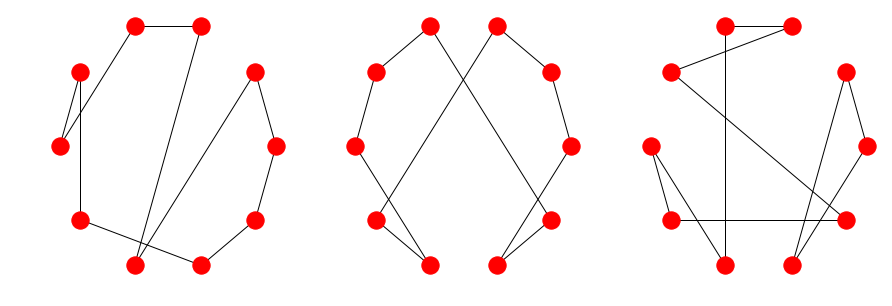

In [295]:
fig, axs = plt.subplots(1,3, figsize=(15,5))
colors = ['red', 'blue', 'green']
for i in range(3):
    nx.draw_circular(reps[i], ax=axs[i])
#plt.savefig("cluster_representative.png", transparent=True, dpi=200, bbox_inches='tight')
plt.show()

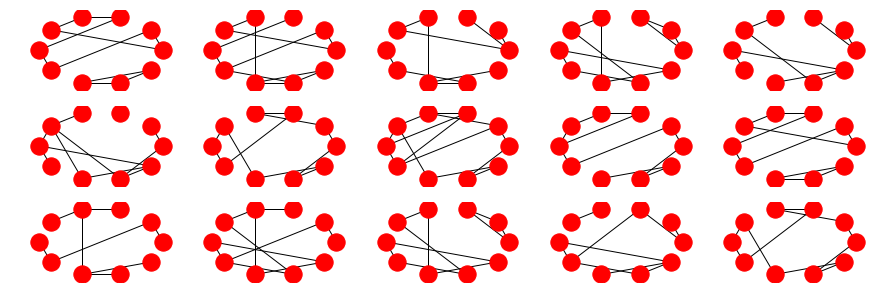

In [340]:
fig, axs = plt.subplots(3,5, figsize=(15,5))
colors = ['red', 'red', 'red', 'blue', 'blue', 'blue']
k = 0
for i in range(3):
    for j in range(5):
        g = nx.from_numpy_array(thetas[k])
        nx.draw_circular(g, ax=axs[i, j])
        k+=1
#plt.savefig("cluster_representative.png", transparent=True, dpi=200, bbox_inches='tight')
plt.show()

In [333]:
from regain.norm import l1_norm
distances = np.zeros((15,15))
for i, t in enumerate(thetas):
    for j, t1 in enumerate(thetas):
        distances[i,j] = l1_norm(t-t1)

In [334]:
distances /= np.max(distances)

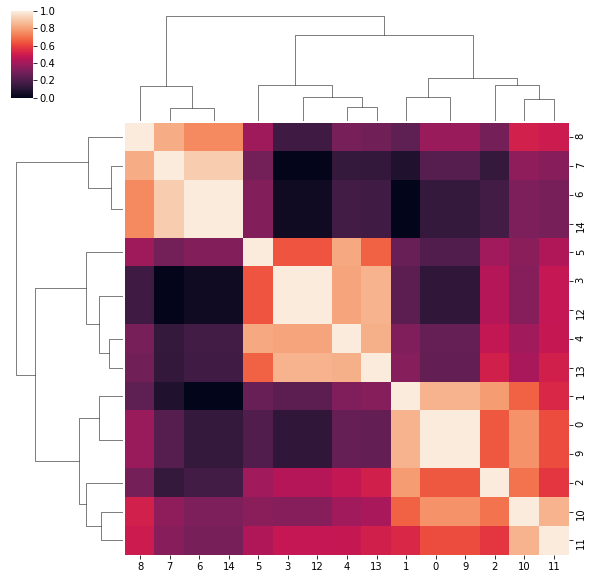

In [335]:
sns.clustermap(1-distances)

In [300]:
X = samples[0]
y = np.zeros(samples[0].shape[0])
for i, s in enumerate(samples[1:]):
    X = np.vstack((X, s))
    y = np.hstack((y, np.ones(s.shape[0])*(i+1)))

In [381]:
from importlib import reload
import regain.clustering; reload(regain.clustering)
import regain.covariance.kernel_time_graphical_lasso_; reload(regain.covariance.kernel_time_graphical_lasso_)
from regain.covariance.kernel_time_graphical_lasso_ import SimilarityTimeGraphicalLasso

In [382]:
stgl = SimilarityTimeGraphicalLasso(alpha=15, psi='l1', verbose=1)
stgl.fit(X, y)

Find new theta
obj: inf, rnorm: 21.1316, snorm: 57.7380,eps_pri: 0.0212, eps_dual: 0.0171
obj: inf, rnorm: 17.3724, snorm: 6.3226,eps_pri: 0.0207, eps_dual: 0.0188
obj: inf, rnorm: 15.8644, snorm: 3.7430,eps_pri: 0.0204, eps_dual: 0.0203
obj: inf, rnorm: 14.8566, snorm: 3.1698,eps_pri: 0.0203, eps_dual: 0.0218
obj: inf, rnorm: 14.2088, snorm: 2.3656,eps_pri: 0.0202, eps_dual: 0.0231
obj: inf, rnorm: 13.7153, snorm: 1.9601,eps_pri: 0.0201, eps_dual: 0.0244
obj: inf, rnorm: 13.3270, snorm: 1.6228,eps_pri: 0.0200, eps_dual: 0.0257
obj: inf, rnorm: 13.0044, snorm: 1.3991,eps_pri: 0.0199, eps_dual: 0.0269
obj: inf, rnorm: 12.7231, snorm: 1.2533,eps_pri: 0.0198, eps_dual: 0.0282
obj: inf, rnorm: 12.2854, snorm: 3.3575,eps_pri: 0.0197, eps_dual: 0.0305
obj: inf, rnorm: 11.6812, snorm: 4.5163,eps_pri: 0.0196, eps_dual: 0.0327
obj: inf, rnorm: 9.8795, snorm: 8.6177,eps_pri: 0.0195, eps_dual: 0.0345
obj: inf, rnorm: 6.1734, snorm: 12.6744,eps_pri: 0.0194, eps_dual: 0.0354
obj: inf, rnorm: 4.0304

/home/vero/git_repos/regain/regain/covariance/time_graphical_lasso_.py:52: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if mode == 'empirical':
/home/vero/git_repos/regain/regain/covariance/time_graphical_lasso_.py:60: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  elif mode == 'zeros':


obj: 17090.1529, rnorm: 1.5862, snorm: 0.7111,eps_pri: 0.0191, eps_dual: 0.0442
obj: 17055.0243, rnorm: 1.5392, snorm: 0.6107,eps_pri: 0.0191, eps_dual: 0.0443
obj: 17047.7238, rnorm: 1.5204, snorm: 0.1692,eps_pri: 0.0191, eps_dual: 0.0445
obj: 17036.7107, rnorm: 1.4937, snorm: 0.2596,eps_pri: 0.0191, eps_dual: 0.0447
obj: 17024.7430, rnorm: 1.4663, snorm: 0.2895,eps_pri: 0.0191, eps_dual: 0.0449
obj: 17004.4626, rnorm: 1.4242, snorm: 0.3940,eps_pri: 0.0191, eps_dual: 0.0450
obj: 16982.0465, rnorm: 1.3894, snorm: 0.4639,eps_pri: 0.0191, eps_dual: 0.0452
obj: 16957.0983, rnorm: 1.3405, snorm: 0.5228,eps_pri: 0.0191, eps_dual: 0.0454
obj: 16941.0491, rnorm: 1.3097, snorm: 0.3167,eps_pri: 0.0191, eps_dual: 0.0455
obj: 16928.5987, rnorm: 1.2840, snorm: 0.3531,eps_pri: 0.0191, eps_dual: 0.0456
obj: 16922.5305, rnorm: 1.2687, snorm: 0.1341,eps_pri: 0.0191, eps_dual: 0.0458
obj: 16913.9608, rnorm: 1.2468, snorm: 0.2328,eps_pri: 0.0191, eps_dual: 0.0459
obj: 16899.5516, rnorm: 1.2180, snorm: 0

/home/vero/git_repos/regain/regain/covariance/kernel_time_graphical_lasso_.py:230: UserWarning: Objective did not converge.
  warnings.warn("Objective did not converge.")


Find new theta
obj: inf, rnorm: 17.7985, snorm: 51.7374,eps_pri: 0.0205, eps_dual: 0.0168
obj: inf, rnorm: 17.2777, snorm: 3.6836,eps_pri: 0.0206, eps_dual: 0.0185
obj: inf, rnorm: 16.0114, snorm: 3.7428,eps_pri: 0.0204, eps_dual: 0.0200
obj: inf, rnorm: 15.0595, snorm: 2.9488,eps_pri: 0.0203, eps_dual: 0.0215
obj: inf, rnorm: 14.3588, snorm: 2.4188,eps_pri: 0.0202, eps_dual: 0.0229
obj: inf, rnorm: 13.8160, snorm: 2.0666,eps_pri: 0.0201, eps_dual: 0.0242
obj: inf, rnorm: 13.3949, snorm: 1.7332,eps_pri: 0.0200, eps_dual: 0.0255
obj: inf, rnorm: 13.0522, snorm: 1.4773,eps_pri: 0.0199, eps_dual: 0.0267
obj: inf, rnorm: 12.7592, snorm: 1.2784,eps_pri: 0.0198, eps_dual: 0.0280
obj: inf, rnorm: 12.5038, snorm: 1.1609,eps_pri: 0.0197, eps_dual: 0.0292
obj: inf, rnorm: 12.0582, snorm: 3.6746,eps_pri: 0.0196, eps_dual: 0.0315
obj: inf, rnorm: 11.1325, snorm: 5.4895,eps_pri: 0.0195, eps_dual: 0.0336
obj: inf, rnorm: 8.2503, snorm: 10.9502,eps_pri: 0.0194, eps_dual: 0.0349
obj: inf, rnorm: 4.820

/home/vero/git_repos/regain/regain/covariance/kernel_time_graphical_lasso_.py:230: UserWarning: Objective did not converge.
  warnings.warn("Objective did not converge.")


Find new theta
obj: inf, rnorm: 17.7713, snorm: 51.7640,eps_pri: 0.0205, eps_dual: 0.0168
obj: inf, rnorm: 17.2902, snorm: 3.5809,eps_pri: 0.0206, eps_dual: 0.0185
obj: inf, rnorm: 16.0201, snorm: 3.6581,eps_pri: 0.0204, eps_dual: 0.0200
obj: inf, rnorm: 15.0586, snorm: 3.0346,eps_pri: 0.0203, eps_dual: 0.0215
obj: inf, rnorm: 14.3506, snorm: 2.4360,eps_pri: 0.0202, eps_dual: 0.0229
obj: inf, rnorm: 13.8061, snorm: 2.0924,eps_pri: 0.0201, eps_dual: 0.0242
obj: inf, rnorm: 13.3876, snorm: 1.7096,eps_pri: 0.0200, eps_dual: 0.0255
obj: inf, rnorm: 13.0486, snorm: 1.4492,eps_pri: 0.0199, eps_dual: 0.0267
obj: inf, rnorm: 12.7551, snorm: 1.3140,eps_pri: 0.0198, eps_dual: 0.0280
obj: inf, rnorm: 12.4966, snorm: 1.1726,eps_pri: 0.0197, eps_dual: 0.0292
obj: inf, rnorm: 12.0639, snorm: 3.5511,eps_pri: 0.0196, eps_dual: 0.0315
obj: inf, rnorm: 11.1336, snorm: 5.5170,eps_pri: 0.0195, eps_dual: 0.0336
obj: inf, rnorm: 8.2323, snorm: 10.9995,eps_pri: 0.0194, eps_dual: 0.0349
obj: inf, rnorm: 4.813

/home/vero/git_repos/regain/regain/covariance/kernel_time_graphical_lasso_.py:230: UserWarning: Objective did not converge.
  warnings.warn("Objective did not converge.")


Find new theta
obj: inf, rnorm: 17.8084, snorm: 51.7602,eps_pri: 0.0205, eps_dual: 0.0168
obj: inf, rnorm: 17.3146, snorm: 3.6522,eps_pri: 0.0206, eps_dual: 0.0185
obj: inf, rnorm: 16.0448, snorm: 3.6407,eps_pri: 0.0204, eps_dual: 0.0201
obj: inf, rnorm: 15.0645, snorm: 3.0661,eps_pri: 0.0203, eps_dual: 0.0215
obj: inf, rnorm: 14.3494, snorm: 2.4395,eps_pri: 0.0202, eps_dual: 0.0229
obj: inf, rnorm: 13.8006, snorm: 2.1140,eps_pri: 0.0201, eps_dual: 0.0242
obj: inf, rnorm: 13.3849, snorm: 1.6872,eps_pri: 0.0200, eps_dual: 0.0255
obj: inf, rnorm: 13.0439, snorm: 1.4349,eps_pri: 0.0199, eps_dual: 0.0267
obj: inf, rnorm: 12.7497, snorm: 1.3013,eps_pri: 0.0198, eps_dual: 0.0280
obj: inf, rnorm: 12.4938, snorm: 1.1688,eps_pri: 0.0197, eps_dual: 0.0292
obj: inf, rnorm: 12.0640, snorm: 3.5331,eps_pri: 0.0196, eps_dual: 0.0315
obj: inf, rnorm: 11.1377, snorm: 5.5066,eps_pri: 0.0195, eps_dual: 0.0336
obj: inf, rnorm: 8.2356, snorm: 11.0008,eps_pri: 0.0194, eps_dual: 0.0349
obj: inf, rnorm: 4.808

/home/vero/git_repos/regain/regain/covariance/kernel_time_graphical_lasso_.py:230: UserWarning: Objective did not converge.
  warnings.warn("Objective did not converge.")


Find new theta
obj: inf, rnorm: 17.8140, snorm: 51.7557,eps_pri: 0.0205, eps_dual: 0.0168
obj: inf, rnorm: 17.3196, snorm: 3.6690,eps_pri: 0.0206, eps_dual: 0.0185
obj: inf, rnorm: 16.0509, snorm: 3.6264,eps_pri: 0.0204, eps_dual: 0.0201
obj: inf, rnorm: 15.0671, snorm: 3.0626,eps_pri: 0.0203, eps_dual: 0.0215
obj: inf, rnorm: 14.3472, snorm: 2.4515,eps_pri: 0.0202, eps_dual: 0.0229
obj: inf, rnorm: 13.7994, snorm: 2.1104,eps_pri: 0.0201, eps_dual: 0.0242
obj: inf, rnorm: 13.3845, snorm: 1.6942,eps_pri: 0.0200, eps_dual: 0.0255
obj: inf, rnorm: 13.0429, snorm: 1.4334,eps_pri: 0.0199, eps_dual: 0.0267
obj: inf, rnorm: 12.7474, snorm: 1.3099,eps_pri: 0.0198, eps_dual: 0.0280
obj: inf, rnorm: 12.4933, snorm: 1.1625,eps_pri: 0.0197, eps_dual: 0.0292
obj: inf, rnorm: 12.0645, snorm: 3.5146,eps_pri: 0.0196, eps_dual: 0.0315
obj: inf, rnorm: 11.1384, snorm: 5.5034,eps_pri: 0.0195, eps_dual: 0.0336
obj: inf, rnorm: 8.2357, snorm: 11.0013,eps_pri: 0.0194, eps_dual: 0.0349
obj: inf, rnorm: 4.807

/home/vero/git_repos/regain/regain/covariance/kernel_time_graphical_lasso_.py:230: UserWarning: Objective did not converge.
  warnings.warn("Objective did not converge.")


Find new theta
obj: inf, rnorm: 17.8164, snorm: 51.7547,eps_pri: 0.0205, eps_dual: 0.0168
obj: inf, rnorm: 17.3214, snorm: 3.6744,eps_pri: 0.0206, eps_dual: 0.0185
obj: inf, rnorm: 16.0529, snorm: 3.6192,eps_pri: 0.0204, eps_dual: 0.0201
obj: inf, rnorm: 15.0683, snorm: 3.0567,eps_pri: 0.0203, eps_dual: 0.0215
obj: inf, rnorm: 14.3462, snorm: 2.4552,eps_pri: 0.0202, eps_dual: 0.0229
obj: inf, rnorm: 13.7989, snorm: 2.1042,eps_pri: 0.0201, eps_dual: 0.0242
obj: inf, rnorm: 13.3843, snorm: 1.6936,eps_pri: 0.0200, eps_dual: 0.0255
obj: inf, rnorm: 13.0425, snorm: 1.4302,eps_pri: 0.0199, eps_dual: 0.0267
obj: inf, rnorm: 12.7466, snorm: 1.3134,eps_pri: 0.0198, eps_dual: 0.0280
obj: inf, rnorm: 12.4929, snorm: 1.1622,eps_pri: 0.0197, eps_dual: 0.0292
obj: inf, rnorm: 12.0647, snorm: 3.5025,eps_pri: 0.0196, eps_dual: 0.0315
obj: inf, rnorm: 11.1389, snorm: 5.5011,eps_pri: 0.0195, eps_dual: 0.0336
obj: inf, rnorm: 8.2357, snorm: 11.0023,eps_pri: 0.0194, eps_dual: 0.0349
obj: inf, rnorm: 4.807

/home/vero/git_repos/regain/regain/covariance/kernel_time_graphical_lasso_.py:230: UserWarning: Objective did not converge.
  warnings.warn("Objective did not converge.")


Find new theta
obj: inf, rnorm: 17.8163, snorm: 51.7547,eps_pri: 0.0205, eps_dual: 0.0168
obj: inf, rnorm: 17.3212, snorm: 3.6771,eps_pri: 0.0206, eps_dual: 0.0185
obj: inf, rnorm: 16.0528, snorm: 3.6182,eps_pri: 0.0204, eps_dual: 0.0201
obj: inf, rnorm: 15.0684, snorm: 3.0547,eps_pri: 0.0203, eps_dual: 0.0215
obj: inf, rnorm: 14.3456, snorm: 2.4570,eps_pri: 0.0202, eps_dual: 0.0229
obj: inf, rnorm: 13.7987, snorm: 2.1023,eps_pri: 0.0201, eps_dual: 0.0242
obj: inf, rnorm: 13.3842, snorm: 1.6938,eps_pri: 0.0200, eps_dual: 0.0255
obj: inf, rnorm: 13.0424, snorm: 1.4289,eps_pri: 0.0199, eps_dual: 0.0267
obj: inf, rnorm: 12.7464, snorm: 1.3137,eps_pri: 0.0198, eps_dual: 0.0280
obj: inf, rnorm: 12.4928, snorm: 1.1616,eps_pri: 0.0197, eps_dual: 0.0292
obj: inf, rnorm: 12.0648, snorm: 3.4999,eps_pri: 0.0196, eps_dual: 0.0315
obj: inf, rnorm: 11.1389, snorm: 5.5011,eps_pri: 0.0195, eps_dual: 0.0336
obj: inf, rnorm: 8.2354, snorm: 11.0033,eps_pri: 0.0194, eps_dual: 0.0349
obj: inf, rnorm: 4.807

/home/vero/git_repos/regain/regain/covariance/kernel_time_graphical_lasso_.py:230: UserWarning: Objective did not converge.
  warnings.warn("Objective did not converge.")


Find new theta
obj: inf, rnorm: 17.8162, snorm: 51.7550,eps_pri: 0.0205, eps_dual: 0.0168
obj: inf, rnorm: 17.3210, snorm: 3.6783,eps_pri: 0.0206, eps_dual: 0.0185
obj: inf, rnorm: 16.0526, snorm: 3.6179,eps_pri: 0.0204, eps_dual: 0.0201
obj: inf, rnorm: 15.0684, snorm: 3.0540,eps_pri: 0.0203, eps_dual: 0.0215
obj: inf, rnorm: 14.3454, snorm: 2.4575,eps_pri: 0.0202, eps_dual: 0.0229
obj: inf, rnorm: 13.7986, snorm: 2.1015,eps_pri: 0.0201, eps_dual: 0.0242
obj: inf, rnorm: 13.3842, snorm: 1.6938,eps_pri: 0.0200, eps_dual: 0.0255
obj: inf, rnorm: 13.0423, snorm: 1.4284,eps_pri: 0.0199, eps_dual: 0.0267
obj: inf, rnorm: 12.7463, snorm: 1.3139,eps_pri: 0.0198, eps_dual: 0.0280
obj: inf, rnorm: 12.4929, snorm: 1.1615,eps_pri: 0.0197, eps_dual: 0.0292
obj: inf, rnorm: 12.0649, snorm: 3.4994,eps_pri: 0.0196, eps_dual: 0.0315
obj: inf, rnorm: 11.1389, snorm: 5.5012,eps_pri: 0.0195, eps_dual: 0.0336
obj: inf, rnorm: 8.2352, snorm: 11.0038,eps_pri: 0.0194, eps_dual: 0.0349
obj: inf, rnorm: 4.807

/home/vero/git_repos/regain/regain/covariance/kernel_time_graphical_lasso_.py:230: UserWarning: Objective did not converge.
  warnings.warn("Objective did not converge.")


Find new theta
obj: inf, rnorm: 17.8161, snorm: 51.7551,eps_pri: 0.0205, eps_dual: 0.0168
obj: inf, rnorm: 17.3208, snorm: 3.6788,eps_pri: 0.0206, eps_dual: 0.0185
obj: inf, rnorm: 16.0525, snorm: 3.6178,eps_pri: 0.0204, eps_dual: 0.0201
obj: inf, rnorm: 15.0684, snorm: 3.0537,eps_pri: 0.0203, eps_dual: 0.0215
obj: inf, rnorm: 14.3453, snorm: 2.4577,eps_pri: 0.0202, eps_dual: 0.0229
obj: inf, rnorm: 13.7986, snorm: 2.1012,eps_pri: 0.0201, eps_dual: 0.0242
obj: inf, rnorm: 13.3842, snorm: 1.6938,eps_pri: 0.0200, eps_dual: 0.0255
obj: inf, rnorm: 13.0423, snorm: 1.4281,eps_pri: 0.0199, eps_dual: 0.0267
obj: inf, rnorm: 12.7463, snorm: 1.3139,eps_pri: 0.0198, eps_dual: 0.0280
obj: inf, rnorm: 12.4929, snorm: 1.1614,eps_pri: 0.0197, eps_dual: 0.0292
obj: inf, rnorm: 12.0649, snorm: 3.4993,eps_pri: 0.0196, eps_dual: 0.0315
obj: inf, rnorm: 11.1389, snorm: 5.5012,eps_pri: 0.0195, eps_dual: 0.0336
obj: inf, rnorm: 8.2351, snorm: 11.0041,eps_pri: 0.0194, eps_dual: 0.0349
obj: inf, rnorm: 4.807

/home/vero/git_repos/regain/regain/covariance/kernel_time_graphical_lasso_.py:230: UserWarning: Objective did not converge.
  warnings.warn("Objective did not converge.")


Find new theta
obj: inf, rnorm: 17.8160, snorm: 51.7552,eps_pri: 0.0205, eps_dual: 0.0168
obj: inf, rnorm: 17.3208, snorm: 3.6790,eps_pri: 0.0206, eps_dual: 0.0185
obj: inf, rnorm: 16.0525, snorm: 3.6177,eps_pri: 0.0204, eps_dual: 0.0201
obj: inf, rnorm: 15.0684, snorm: 3.0536,eps_pri: 0.0203, eps_dual: 0.0215
obj: inf, rnorm: 14.3453, snorm: 2.4577,eps_pri: 0.0202, eps_dual: 0.0229
obj: inf, rnorm: 13.7986, snorm: 2.1012,eps_pri: 0.0201, eps_dual: 0.0242
obj: inf, rnorm: 13.3842, snorm: 1.6937,eps_pri: 0.0200, eps_dual: 0.0255
obj: inf, rnorm: 13.0423, snorm: 1.4281,eps_pri: 0.0199, eps_dual: 0.0267
obj: inf, rnorm: 12.7463, snorm: 1.3140,eps_pri: 0.0198, eps_dual: 0.0280
obj: inf, rnorm: 12.4929, snorm: 1.1614,eps_pri: 0.0197, eps_dual: 0.0292
obj: inf, rnorm: 12.0649, snorm: 3.4993,eps_pri: 0.0196, eps_dual: 0.0315
obj: inf, rnorm: 11.1389, snorm: 5.5012,eps_pri: 0.0195, eps_dual: 0.0336
obj: inf, rnorm: 8.2351, snorm: 11.0042,eps_pri: 0.0194, eps_dual: 0.0349
obj: inf, rnorm: 4.807

/home/vero/git_repos/regain/regain/covariance/kernel_time_graphical_lasso_.py:230: UserWarning: Objective did not converge.
  warnings.warn("Objective did not converge.")


Find new theta
obj: inf, rnorm: 17.8163, snorm: 51.7551,eps_pri: 0.0205, eps_dual: 0.0168
obj: inf, rnorm: 17.3211, snorm: 3.6787,eps_pri: 0.0206, eps_dual: 0.0185
obj: inf, rnorm: 16.0528, snorm: 3.6171,eps_pri: 0.0204, eps_dual: 0.0201
obj: inf, rnorm: 15.0685, snorm: 3.0537,eps_pri: 0.0203, eps_dual: 0.0215
obj: inf, rnorm: 14.3454, snorm: 2.4576,eps_pri: 0.0202, eps_dual: 0.0229
obj: inf, rnorm: 13.7987, snorm: 2.1010,eps_pri: 0.0201, eps_dual: 0.0242
obj: inf, rnorm: 13.3842, snorm: 1.6936,eps_pri: 0.0200, eps_dual: 0.0255
obj: inf, rnorm: 13.0423, snorm: 1.4277,eps_pri: 0.0199, eps_dual: 0.0267
obj: inf, rnorm: 12.7463, snorm: 1.3142,eps_pri: 0.0198, eps_dual: 0.0280
obj: inf, rnorm: 12.4929, snorm: 1.1615,eps_pri: 0.0197, eps_dual: 0.0292
obj: inf, rnorm: 12.0649, snorm: 3.4990,eps_pri: 0.0196, eps_dual: 0.0315
obj: inf, rnorm: 11.1390, snorm: 5.5006,eps_pri: 0.0195, eps_dual: 0.0336
obj: inf, rnorm: 8.2352, snorm: 11.0041,eps_pri: 0.0194, eps_dual: 0.0349
obj: inf, rnorm: 4.807

/home/vero/git_repos/regain/regain/covariance/kernel_time_graphical_lasso_.py:230: UserWarning: Objective did not converge.
  warnings.warn("Objective did not converge.")


Find new theta
obj: inf, rnorm: 17.8160, snorm: 51.7552,eps_pri: 0.0205, eps_dual: 0.0168
obj: inf, rnorm: 17.3208, snorm: 3.6791,eps_pri: 0.0206, eps_dual: 0.0185
obj: inf, rnorm: 16.0525, snorm: 3.6176,eps_pri: 0.0204, eps_dual: 0.0201
obj: inf, rnorm: 15.0684, snorm: 3.0535,eps_pri: 0.0203, eps_dual: 0.0215
obj: inf, rnorm: 14.3453, snorm: 2.4578,eps_pri: 0.0202, eps_dual: 0.0229
obj: inf, rnorm: 13.7986, snorm: 2.1010,eps_pri: 0.0201, eps_dual: 0.0242
obj: inf, rnorm: 13.3842, snorm: 1.6937,eps_pri: 0.0200, eps_dual: 0.0255
obj: inf, rnorm: 13.0423, snorm: 1.4280,eps_pri: 0.0199, eps_dual: 0.0267
obj: inf, rnorm: 12.7463, snorm: 1.3140,eps_pri: 0.0198, eps_dual: 0.0280
obj: inf, rnorm: 12.4929, snorm: 1.1614,eps_pri: 0.0197, eps_dual: 0.0292
obj: inf, rnorm: 12.0649, snorm: 3.4992,eps_pri: 0.0196, eps_dual: 0.0315
obj: inf, rnorm: 11.1390, snorm: 5.5011,eps_pri: 0.0195, eps_dual: 0.0336
obj: inf, rnorm: 8.2351, snorm: 11.0043,eps_pri: 0.0194, eps_dual: 0.0349
obj: inf, rnorm: 4.807

/home/vero/git_repos/regain/regain/covariance/kernel_time_graphical_lasso_.py:230: UserWarning: Objective did not converge.
  warnings.warn("Objective did not converge.")


Find new theta
obj: inf, rnorm: 17.8163, snorm: 51.7551,eps_pri: 0.0205, eps_dual: 0.0168
obj: inf, rnorm: 17.3211, snorm: 3.6787,eps_pri: 0.0206, eps_dual: 0.0185
obj: inf, rnorm: 16.0528, snorm: 3.6171,eps_pri: 0.0204, eps_dual: 0.0201
obj: inf, rnorm: 15.0685, snorm: 3.0537,eps_pri: 0.0203, eps_dual: 0.0215
obj: inf, rnorm: 14.3454, snorm: 2.4577,eps_pri: 0.0202, eps_dual: 0.0229
obj: inf, rnorm: 13.7987, snorm: 2.1010,eps_pri: 0.0201, eps_dual: 0.0242
obj: inf, rnorm: 13.3842, snorm: 1.6936,eps_pri: 0.0200, eps_dual: 0.0255
obj: inf, rnorm: 13.0423, snorm: 1.4277,eps_pri: 0.0199, eps_dual: 0.0267
obj: inf, rnorm: 12.7463, snorm: 1.3143,eps_pri: 0.0198, eps_dual: 0.0280
obj: inf, rnorm: 12.4929, snorm: 1.1615,eps_pri: 0.0197, eps_dual: 0.0292
obj: inf, rnorm: 12.0649, snorm: 3.4990,eps_pri: 0.0196, eps_dual: 0.0315
obj: inf, rnorm: 11.1390, snorm: 5.5006,eps_pri: 0.0195, eps_dual: 0.0336
obj: inf, rnorm: 8.2352, snorm: 11.0042,eps_pri: 0.0194, eps_dual: 0.0349
obj: inf, rnorm: 4.807

/home/vero/git_repos/regain/regain/covariance/kernel_time_graphical_lasso_.py:230: UserWarning: Objective did not converge.
  warnings.warn("Objective did not converge.")


Find new theta
obj: inf, rnorm: 17.8160, snorm: 51.7552,eps_pri: 0.0205, eps_dual: 0.0168
obj: inf, rnorm: 17.3208, snorm: 3.6790,eps_pri: 0.0206, eps_dual: 0.0185
obj: inf, rnorm: 16.0525, snorm: 3.6176,eps_pri: 0.0204, eps_dual: 0.0201
obj: inf, rnorm: 15.0684, snorm: 3.0535,eps_pri: 0.0203, eps_dual: 0.0215
obj: inf, rnorm: 14.3453, snorm: 2.4578,eps_pri: 0.0202, eps_dual: 0.0229
obj: inf, rnorm: 13.7986, snorm: 2.1010,eps_pri: 0.0201, eps_dual: 0.0242
obj: inf, rnorm: 13.3842, snorm: 1.6937,eps_pri: 0.0200, eps_dual: 0.0255
obj: inf, rnorm: 13.0423, snorm: 1.4279,eps_pri: 0.0199, eps_dual: 0.0267
obj: inf, rnorm: 12.7463, snorm: 1.3140,eps_pri: 0.0198, eps_dual: 0.0280
obj: inf, rnorm: 12.4929, snorm: 1.1614,eps_pri: 0.0197, eps_dual: 0.0292
obj: inf, rnorm: 12.0649, snorm: 3.4992,eps_pri: 0.0196, eps_dual: 0.0315
obj: inf, rnorm: 11.1390, snorm: 5.5011,eps_pri: 0.0195, eps_dual: 0.0336
obj: inf, rnorm: 8.2351, snorm: 11.0043,eps_pri: 0.0194, eps_dual: 0.0349
obj: inf, rnorm: 4.807

/home/vero/git_repos/regain/regain/covariance/kernel_time_graphical_lasso_.py:230: UserWarning: Objective did not converge.
  warnings.warn("Objective did not converge.")


Find new theta
obj: inf, rnorm: 17.8163, snorm: 51.7551,eps_pri: 0.0205, eps_dual: 0.0168
obj: inf, rnorm: 17.3211, snorm: 3.6787,eps_pri: 0.0206, eps_dual: 0.0185
obj: inf, rnorm: 16.0528, snorm: 3.6171,eps_pri: 0.0204, eps_dual: 0.0201
obj: inf, rnorm: 15.0685, snorm: 3.0537,eps_pri: 0.0203, eps_dual: 0.0215
obj: inf, rnorm: 14.3454, snorm: 2.4577,eps_pri: 0.0202, eps_dual: 0.0229
obj: inf, rnorm: 13.7987, snorm: 2.1010,eps_pri: 0.0201, eps_dual: 0.0242
obj: inf, rnorm: 13.3842, snorm: 1.6936,eps_pri: 0.0200, eps_dual: 0.0255
obj: inf, rnorm: 13.0423, snorm: 1.4277,eps_pri: 0.0199, eps_dual: 0.0267
obj: inf, rnorm: 12.7463, snorm: 1.3143,eps_pri: 0.0198, eps_dual: 0.0280
obj: inf, rnorm: 12.4929, snorm: 1.1615,eps_pri: 0.0197, eps_dual: 0.0292
obj: inf, rnorm: 12.0649, snorm: 3.4990,eps_pri: 0.0196, eps_dual: 0.0315
obj: inf, rnorm: 11.1390, snorm: 5.5006,eps_pri: 0.0195, eps_dual: 0.0336
obj: inf, rnorm: 8.2352, snorm: 11.0042,eps_pri: 0.0194, eps_dual: 0.0349
obj: inf, rnorm: 4.807

/home/vero/git_repos/regain/regain/covariance/kernel_time_graphical_lasso_.py:230: UserWarning: Objective did not converge.
  warnings.warn("Objective did not converge.")


Find new theta
obj: inf, rnorm: 17.8160, snorm: 51.7552,eps_pri: 0.0205, eps_dual: 0.0168
obj: inf, rnorm: 17.3208, snorm: 3.6791,eps_pri: 0.0206, eps_dual: 0.0185
obj: inf, rnorm: 16.0525, snorm: 3.6176,eps_pri: 0.0204, eps_dual: 0.0201
obj: inf, rnorm: 15.0684, snorm: 3.0535,eps_pri: 0.0203, eps_dual: 0.0215
obj: inf, rnorm: 14.3453, snorm: 2.4578,eps_pri: 0.0202, eps_dual: 0.0229
obj: inf, rnorm: 13.7986, snorm: 2.1010,eps_pri: 0.0201, eps_dual: 0.0242
obj: inf, rnorm: 13.3842, snorm: 1.6937,eps_pri: 0.0200, eps_dual: 0.0255
obj: inf, rnorm: 13.0423, snorm: 1.4279,eps_pri: 0.0199, eps_dual: 0.0267
obj: inf, rnorm: 12.7463, snorm: 1.3140,eps_pri: 0.0198, eps_dual: 0.0280
obj: inf, rnorm: 12.4929, snorm: 1.1614,eps_pri: 0.0197, eps_dual: 0.0292
obj: inf, rnorm: 12.0649, snorm: 3.4992,eps_pri: 0.0196, eps_dual: 0.0315
obj: inf, rnorm: 11.1390, snorm: 5.5011,eps_pri: 0.0195, eps_dual: 0.0336
obj: inf, rnorm: 8.2351, snorm: 11.0043,eps_pri: 0.0194, eps_dual: 0.0349
obj: inf, rnorm: 4.807

/home/vero/git_repos/regain/regain/covariance/kernel_time_graphical_lasso_.py:230: UserWarning: Objective did not converge.
  warnings.warn("Objective did not converge.")


Find new theta
obj: inf, rnorm: 17.8163, snorm: 51.7551,eps_pri: 0.0205, eps_dual: 0.0168
obj: inf, rnorm: 17.3211, snorm: 3.6787,eps_pri: 0.0206, eps_dual: 0.0185
obj: inf, rnorm: 16.0528, snorm: 3.6171,eps_pri: 0.0204, eps_dual: 0.0201
obj: inf, rnorm: 15.0685, snorm: 3.0537,eps_pri: 0.0203, eps_dual: 0.0215
obj: inf, rnorm: 14.3454, snorm: 2.4577,eps_pri: 0.0202, eps_dual: 0.0229
obj: inf, rnorm: 13.7987, snorm: 2.1010,eps_pri: 0.0201, eps_dual: 0.0242
obj: inf, rnorm: 13.3842, snorm: 1.6936,eps_pri: 0.0200, eps_dual: 0.0255
obj: inf, rnorm: 13.0423, snorm: 1.4277,eps_pri: 0.0199, eps_dual: 0.0267
obj: inf, rnorm: 12.7463, snorm: 1.3143,eps_pri: 0.0198, eps_dual: 0.0280
obj: inf, rnorm: 12.4929, snorm: 1.1615,eps_pri: 0.0197, eps_dual: 0.0292
obj: inf, rnorm: 12.0649, snorm: 3.4990,eps_pri: 0.0196, eps_dual: 0.0315
obj: inf, rnorm: 11.1390, snorm: 5.5006,eps_pri: 0.0195, eps_dual: 0.0336
obj: inf, rnorm: 8.2352, snorm: 11.0042,eps_pri: 0.0194, eps_dual: 0.0349
obj: inf, rnorm: 4.807

/home/vero/git_repos/regain/regain/covariance/kernel_time_graphical_lasso_.py:230: UserWarning: Objective did not converge.
  warnings.warn("Objective did not converge.")


Find new theta
obj: inf, rnorm: 17.8160, snorm: 51.7552,eps_pri: 0.0205, eps_dual: 0.0168
obj: inf, rnorm: 17.3208, snorm: 3.6791,eps_pri: 0.0206, eps_dual: 0.0185
obj: inf, rnorm: 16.0525, snorm: 3.6176,eps_pri: 0.0204, eps_dual: 0.0201
obj: inf, rnorm: 15.0684, snorm: 3.0535,eps_pri: 0.0203, eps_dual: 0.0215
obj: inf, rnorm: 14.3453, snorm: 2.4578,eps_pri: 0.0202, eps_dual: 0.0229
obj: inf, rnorm: 13.7986, snorm: 2.1010,eps_pri: 0.0201, eps_dual: 0.0242
obj: inf, rnorm: 13.3842, snorm: 1.6937,eps_pri: 0.0200, eps_dual: 0.0255
obj: inf, rnorm: 13.0423, snorm: 1.4279,eps_pri: 0.0199, eps_dual: 0.0267
obj: inf, rnorm: 12.7463, snorm: 1.3140,eps_pri: 0.0198, eps_dual: 0.0280
obj: inf, rnorm: 12.4929, snorm: 1.1614,eps_pri: 0.0197, eps_dual: 0.0292
obj: inf, rnorm: 12.0649, snorm: 3.4992,eps_pri: 0.0196, eps_dual: 0.0315
obj: inf, rnorm: 11.1390, snorm: 5.5011,eps_pri: 0.0195, eps_dual: 0.0336
obj: inf, rnorm: 8.2351, snorm: 11.0043,eps_pri: 0.0194, eps_dual: 0.0349
obj: inf, rnorm: 4.807

/home/vero/git_repos/regain/regain/covariance/kernel_time_graphical_lasso_.py:230: UserWarning: Objective did not converge.
  warnings.warn("Objective did not converge.")


Find new theta
obj: inf, rnorm: 17.8163, snorm: 51.7551,eps_pri: 0.0205, eps_dual: 0.0168
obj: inf, rnorm: 17.3211, snorm: 3.6787,eps_pri: 0.0206, eps_dual: 0.0185
obj: inf, rnorm: 16.0528, snorm: 3.6171,eps_pri: 0.0204, eps_dual: 0.0201
obj: inf, rnorm: 15.0685, snorm: 3.0537,eps_pri: 0.0203, eps_dual: 0.0215
obj: inf, rnorm: 14.3454, snorm: 2.4577,eps_pri: 0.0202, eps_dual: 0.0229
obj: inf, rnorm: 13.7987, snorm: 2.1010,eps_pri: 0.0201, eps_dual: 0.0242
obj: inf, rnorm: 13.3842, snorm: 1.6936,eps_pri: 0.0200, eps_dual: 0.0255
obj: inf, rnorm: 13.0423, snorm: 1.4277,eps_pri: 0.0199, eps_dual: 0.0267
obj: inf, rnorm: 12.7463, snorm: 1.3143,eps_pri: 0.0198, eps_dual: 0.0280
obj: inf, rnorm: 12.4929, snorm: 1.1615,eps_pri: 0.0197, eps_dual: 0.0292
obj: inf, rnorm: 12.0649, snorm: 3.4990,eps_pri: 0.0196, eps_dual: 0.0315
obj: inf, rnorm: 11.1390, snorm: 5.5006,eps_pri: 0.0195, eps_dual: 0.0336
obj: inf, rnorm: 8.2352, snorm: 11.0042,eps_pri: 0.0194, eps_dual: 0.0349
obj: inf, rnorm: 4.807

/home/vero/git_repos/regain/regain/covariance/kernel_time_graphical_lasso_.py:230: UserWarning: Objective did not converge.
  warnings.warn("Objective did not converge.")


Find new theta
obj: inf, rnorm: 17.8160, snorm: 51.7552,eps_pri: 0.0205, eps_dual: 0.0168
obj: inf, rnorm: 17.3208, snorm: 3.6791,eps_pri: 0.0206, eps_dual: 0.0185
obj: inf, rnorm: 16.0525, snorm: 3.6176,eps_pri: 0.0204, eps_dual: 0.0201
obj: inf, rnorm: 15.0684, snorm: 3.0535,eps_pri: 0.0203, eps_dual: 0.0215
obj: inf, rnorm: 14.3453, snorm: 2.4578,eps_pri: 0.0202, eps_dual: 0.0229
obj: inf, rnorm: 13.7986, snorm: 2.1010,eps_pri: 0.0201, eps_dual: 0.0242
obj: inf, rnorm: 13.3842, snorm: 1.6937,eps_pri: 0.0200, eps_dual: 0.0255
obj: inf, rnorm: 13.0423, snorm: 1.4279,eps_pri: 0.0199, eps_dual: 0.0267
obj: inf, rnorm: 12.7463, snorm: 1.3140,eps_pri: 0.0198, eps_dual: 0.0280
obj: inf, rnorm: 12.4929, snorm: 1.1614,eps_pri: 0.0197, eps_dual: 0.0292
obj: inf, rnorm: 12.0649, snorm: 3.4992,eps_pri: 0.0196, eps_dual: 0.0315
obj: inf, rnorm: 11.1390, snorm: 5.5010,eps_pri: 0.0195, eps_dual: 0.0336
obj: inf, rnorm: 8.2351, snorm: 11.0043,eps_pri: 0.0194, eps_dual: 0.0349
obj: inf, rnorm: 4.807

/home/vero/git_repos/regain/regain/covariance/kernel_time_graphical_lasso_.py:230: UserWarning: Objective did not converge.
  warnings.warn("Objective did not converge.")


Find new theta
obj: inf, rnorm: 17.8163, snorm: 51.7551,eps_pri: 0.0205, eps_dual: 0.0168
obj: inf, rnorm: 17.3210, snorm: 3.6787,eps_pri: 0.0206, eps_dual: 0.0185
obj: inf, rnorm: 16.0528, snorm: 3.6171,eps_pri: 0.0204, eps_dual: 0.0201
obj: inf, rnorm: 15.0685, snorm: 3.0537,eps_pri: 0.0203, eps_dual: 0.0215
obj: inf, rnorm: 14.3454, snorm: 2.4577,eps_pri: 0.0202, eps_dual: 0.0229
obj: inf, rnorm: 13.7987, snorm: 2.1010,eps_pri: 0.0201, eps_dual: 0.0242
obj: inf, rnorm: 13.3842, snorm: 1.6936,eps_pri: 0.0200, eps_dual: 0.0255
obj: inf, rnorm: 13.0423, snorm: 1.4277,eps_pri: 0.0199, eps_dual: 0.0267
obj: inf, rnorm: 12.7463, snorm: 1.3143,eps_pri: 0.0198, eps_dual: 0.0280
obj: inf, rnorm: 12.4929, snorm: 1.1615,eps_pri: 0.0197, eps_dual: 0.0292
obj: inf, rnorm: 12.0649, snorm: 3.4990,eps_pri: 0.0196, eps_dual: 0.0315
obj: inf, rnorm: 11.1390, snorm: 5.5006,eps_pri: 0.0195, eps_dual: 0.0336
obj: inf, rnorm: 8.2352, snorm: 11.0042,eps_pri: 0.0194, eps_dual: 0.0349
obj: inf, rnorm: 4.807

/home/vero/git_repos/regain/regain/covariance/kernel_time_graphical_lasso_.py:230: UserWarning: Objective did not converge.
  warnings.warn("Objective did not converge.")


Find new theta
obj: inf, rnorm: 17.8160, snorm: 51.7552,eps_pri: 0.0205, eps_dual: 0.0168
obj: inf, rnorm: 17.3208, snorm: 3.6791,eps_pri: 0.0206, eps_dual: 0.0185
obj: inf, rnorm: 16.0525, snorm: 3.6176,eps_pri: 0.0204, eps_dual: 0.0201
obj: inf, rnorm: 15.0684, snorm: 3.0535,eps_pri: 0.0203, eps_dual: 0.0215
obj: inf, rnorm: 14.3453, snorm: 2.4578,eps_pri: 0.0202, eps_dual: 0.0229
obj: inf, rnorm: 13.7986, snorm: 2.1011,eps_pri: 0.0201, eps_dual: 0.0242
obj: inf, rnorm: 13.3842, snorm: 1.6937,eps_pri: 0.0200, eps_dual: 0.0255
obj: inf, rnorm: 13.0423, snorm: 1.4279,eps_pri: 0.0199, eps_dual: 0.0267
obj: inf, rnorm: 12.7463, snorm: 1.3140,eps_pri: 0.0198, eps_dual: 0.0280
obj: inf, rnorm: 12.4929, snorm: 1.1614,eps_pri: 0.0197, eps_dual: 0.0292
obj: inf, rnorm: 12.0649, snorm: 3.4992,eps_pri: 0.0196, eps_dual: 0.0315
obj: inf, rnorm: 11.1390, snorm: 5.5011,eps_pri: 0.0195, eps_dual: 0.0336
obj: inf, rnorm: 8.2351, snorm: 11.0043,eps_pri: 0.0194, eps_dual: 0.0349
obj: inf, rnorm: 4.807

/home/vero/git_repos/regain/regain/covariance/kernel_time_graphical_lasso_.py:230: UserWarning: Objective did not converge.
  warnings.warn("Objective did not converge.")


Find new theta
obj: inf, rnorm: 17.8163, snorm: 51.7551,eps_pri: 0.0205, eps_dual: 0.0168
obj: inf, rnorm: 17.3211, snorm: 3.6787,eps_pri: 0.0206, eps_dual: 0.0185
obj: inf, rnorm: 16.0528, snorm: 3.6171,eps_pri: 0.0204, eps_dual: 0.0201
obj: inf, rnorm: 15.0685, snorm: 3.0537,eps_pri: 0.0203, eps_dual: 0.0215
obj: inf, rnorm: 14.3454, snorm: 2.4577,eps_pri: 0.0202, eps_dual: 0.0229
obj: inf, rnorm: 13.7987, snorm: 2.1010,eps_pri: 0.0201, eps_dual: 0.0242
obj: inf, rnorm: 13.3842, snorm: 1.6936,eps_pri: 0.0200, eps_dual: 0.0255
obj: inf, rnorm: 13.0423, snorm: 1.4277,eps_pri: 0.0199, eps_dual: 0.0267
obj: inf, rnorm: 12.7463, snorm: 1.3143,eps_pri: 0.0198, eps_dual: 0.0280
obj: inf, rnorm: 12.4929, snorm: 1.1615,eps_pri: 0.0197, eps_dual: 0.0292
obj: inf, rnorm: 12.0649, snorm: 3.4990,eps_pri: 0.0196, eps_dual: 0.0315
obj: inf, rnorm: 11.1390, snorm: 5.5006,eps_pri: 0.0195, eps_dual: 0.0336
obj: inf, rnorm: 8.2352, snorm: 11.0042,eps_pri: 0.0194, eps_dual: 0.0349
obj: inf, rnorm: 4.807

/home/vero/git_repos/regain/regain/covariance/kernel_time_graphical_lasso_.py:230: UserWarning: Objective did not converge.
  warnings.warn("Objective did not converge.")


Find new theta
obj: inf, rnorm: 17.8160, snorm: 51.7552,eps_pri: 0.0205, eps_dual: 0.0168
obj: inf, rnorm: 17.3208, snorm: 3.6791,eps_pri: 0.0206, eps_dual: 0.0185
obj: inf, rnorm: 16.0525, snorm: 3.6176,eps_pri: 0.0204, eps_dual: 0.0201
obj: inf, rnorm: 15.0684, snorm: 3.0535,eps_pri: 0.0203, eps_dual: 0.0215
obj: inf, rnorm: 14.3453, snorm: 2.4578,eps_pri: 0.0202, eps_dual: 0.0229
obj: inf, rnorm: 13.7986, snorm: 2.1010,eps_pri: 0.0201, eps_dual: 0.0242
obj: inf, rnorm: 13.3842, snorm: 1.6937,eps_pri: 0.0200, eps_dual: 0.0255
obj: inf, rnorm: 13.0423, snorm: 1.4279,eps_pri: 0.0199, eps_dual: 0.0267
obj: inf, rnorm: 12.7463, snorm: 1.3140,eps_pri: 0.0198, eps_dual: 0.0280
obj: inf, rnorm: 12.4929, snorm: 1.1614,eps_pri: 0.0197, eps_dual: 0.0292
obj: inf, rnorm: 12.0649, snorm: 3.4992,eps_pri: 0.0196, eps_dual: 0.0315
obj: inf, rnorm: 11.1390, snorm: 5.5011,eps_pri: 0.0195, eps_dual: 0.0336
obj: inf, rnorm: 8.2351, snorm: 11.0043,eps_pri: 0.0194, eps_dual: 0.0349
obj: inf, rnorm: 4.807

/home/vero/git_repos/regain/regain/covariance/kernel_time_graphical_lasso_.py:230: UserWarning: Objective did not converge.
  warnings.warn("Objective did not converge.")


Find new theta
obj: inf, rnorm: 17.8163, snorm: 51.7551,eps_pri: 0.0205, eps_dual: 0.0168
obj: inf, rnorm: 17.3211, snorm: 3.6787,eps_pri: 0.0206, eps_dual: 0.0185
obj: inf, rnorm: 16.0528, snorm: 3.6171,eps_pri: 0.0204, eps_dual: 0.0201
obj: inf, rnorm: 15.0685, snorm: 3.0537,eps_pri: 0.0203, eps_dual: 0.0215
obj: inf, rnorm: 14.3454, snorm: 2.4577,eps_pri: 0.0202, eps_dual: 0.0229
obj: inf, rnorm: 13.7987, snorm: 2.1010,eps_pri: 0.0201, eps_dual: 0.0242
obj: inf, rnorm: 13.3842, snorm: 1.6936,eps_pri: 0.0200, eps_dual: 0.0255
obj: inf, rnorm: 13.0423, snorm: 1.4277,eps_pri: 0.0199, eps_dual: 0.0267
obj: inf, rnorm: 12.7463, snorm: 1.3143,eps_pri: 0.0198, eps_dual: 0.0280
obj: inf, rnorm: 12.4929, snorm: 1.1615,eps_pri: 0.0197, eps_dual: 0.0292
obj: inf, rnorm: 12.0649, snorm: 3.4990,eps_pri: 0.0196, eps_dual: 0.0315
obj: inf, rnorm: 11.1390, snorm: 5.5006,eps_pri: 0.0195, eps_dual: 0.0336
obj: inf, rnorm: 8.2352, snorm: 11.0042,eps_pri: 0.0194, eps_dual: 0.0349
obj: inf, rnorm: 4.807

/home/vero/git_repos/regain/regain/covariance/kernel_time_graphical_lasso_.py:230: UserWarning: Objective did not converge.
  warnings.warn("Objective did not converge.")


Find new theta
obj: inf, rnorm: 17.8160, snorm: 51.7552,eps_pri: 0.0205, eps_dual: 0.0168
obj: inf, rnorm: 17.3208, snorm: 3.6791,eps_pri: 0.0206, eps_dual: 0.0185
obj: inf, rnorm: 16.0525, snorm: 3.6176,eps_pri: 0.0204, eps_dual: 0.0201
obj: inf, rnorm: 15.0684, snorm: 3.0535,eps_pri: 0.0203, eps_dual: 0.0215
obj: inf, rnorm: 14.3453, snorm: 2.4578,eps_pri: 0.0202, eps_dual: 0.0229
obj: inf, rnorm: 13.7986, snorm: 2.1010,eps_pri: 0.0201, eps_dual: 0.0242
obj: inf, rnorm: 13.3842, snorm: 1.6937,eps_pri: 0.0200, eps_dual: 0.0255
obj: inf, rnorm: 13.0423, snorm: 1.4279,eps_pri: 0.0199, eps_dual: 0.0267
obj: inf, rnorm: 12.7463, snorm: 1.3140,eps_pri: 0.0198, eps_dual: 0.0280
obj: inf, rnorm: 12.4929, snorm: 1.1614,eps_pri: 0.0197, eps_dual: 0.0292
obj: inf, rnorm: 12.0649, snorm: 3.4992,eps_pri: 0.0196, eps_dual: 0.0315
obj: inf, rnorm: 11.1390, snorm: 5.5011,eps_pri: 0.0195, eps_dual: 0.0336
obj: inf, rnorm: 8.2351, snorm: 11.0043,eps_pri: 0.0194, eps_dual: 0.0349
obj: inf, rnorm: 4.807

/home/vero/git_repos/regain/regain/covariance/kernel_time_graphical_lasso_.py:230: UserWarning: Objective did not converge.
  warnings.warn("Objective did not converge.")


Find new theta
obj: inf, rnorm: 17.8163, snorm: 51.7551,eps_pri: 0.0205, eps_dual: 0.0168
obj: inf, rnorm: 17.3211, snorm: 3.6787,eps_pri: 0.0206, eps_dual: 0.0185
obj: inf, rnorm: 16.0528, snorm: 3.6171,eps_pri: 0.0204, eps_dual: 0.0201
obj: inf, rnorm: 15.0685, snorm: 3.0537,eps_pri: 0.0203, eps_dual: 0.0215
obj: inf, rnorm: 14.3454, snorm: 2.4577,eps_pri: 0.0202, eps_dual: 0.0229
obj: inf, rnorm: 13.7987, snorm: 2.1010,eps_pri: 0.0201, eps_dual: 0.0242
obj: inf, rnorm: 13.3842, snorm: 1.6936,eps_pri: 0.0200, eps_dual: 0.0255
obj: inf, rnorm: 13.0423, snorm: 1.4277,eps_pri: 0.0199, eps_dual: 0.0267
obj: inf, rnorm: 12.7463, snorm: 1.3143,eps_pri: 0.0198, eps_dual: 0.0280
obj: inf, rnorm: 12.4929, snorm: 1.1615,eps_pri: 0.0197, eps_dual: 0.0292
obj: inf, rnorm: 12.0649, snorm: 3.4990,eps_pri: 0.0196, eps_dual: 0.0315
obj: inf, rnorm: 11.1390, snorm: 5.5006,eps_pri: 0.0195, eps_dual: 0.0336
obj: inf, rnorm: 8.2352, snorm: 11.0042,eps_pri: 0.0194, eps_dual: 0.0349
obj: inf, rnorm: 4.807

/home/vero/git_repos/regain/regain/covariance/kernel_time_graphical_lasso_.py:230: UserWarning: Objective did not converge.
  warnings.warn("Objective did not converge.")


Find new theta
obj: inf, rnorm: 17.8160, snorm: 51.7552,eps_pri: 0.0205, eps_dual: 0.0168
obj: inf, rnorm: 17.3208, snorm: 3.6791,eps_pri: 0.0206, eps_dual: 0.0185
obj: inf, rnorm: 16.0525, snorm: 3.6176,eps_pri: 0.0204, eps_dual: 0.0201
obj: inf, rnorm: 15.0684, snorm: 3.0535,eps_pri: 0.0203, eps_dual: 0.0215
obj: inf, rnorm: 14.3453, snorm: 2.4578,eps_pri: 0.0202, eps_dual: 0.0229
obj: inf, rnorm: 13.7986, snorm: 2.1010,eps_pri: 0.0201, eps_dual: 0.0242
obj: inf, rnorm: 13.3842, snorm: 1.6937,eps_pri: 0.0200, eps_dual: 0.0255
obj: inf, rnorm: 13.0423, snorm: 1.4279,eps_pri: 0.0199, eps_dual: 0.0267
obj: inf, rnorm: 12.7463, snorm: 1.3140,eps_pri: 0.0198, eps_dual: 0.0280
obj: inf, rnorm: 12.4929, snorm: 1.1614,eps_pri: 0.0197, eps_dual: 0.0292
obj: inf, rnorm: 12.0649, snorm: 3.4992,eps_pri: 0.0196, eps_dual: 0.0315
obj: inf, rnorm: 11.1390, snorm: 5.5011,eps_pri: 0.0195, eps_dual: 0.0336
obj: inf, rnorm: 8.2351, snorm: 11.0043,eps_pri: 0.0194, eps_dual: 0.0349
obj: inf, rnorm: 4.807

/home/vero/git_repos/regain/regain/covariance/kernel_time_graphical_lasso_.py:230: UserWarning: Objective did not converge.
  warnings.warn("Objective did not converge.")


Find new theta
obj: inf, rnorm: 17.8163, snorm: 51.7551,eps_pri: 0.0205, eps_dual: 0.0168
obj: inf, rnorm: 17.3211, snorm: 3.6787,eps_pri: 0.0206, eps_dual: 0.0185
obj: inf, rnorm: 16.0528, snorm: 3.6171,eps_pri: 0.0204, eps_dual: 0.0201
obj: inf, rnorm: 15.0685, snorm: 3.0537,eps_pri: 0.0203, eps_dual: 0.0215
obj: inf, rnorm: 14.3454, snorm: 2.4577,eps_pri: 0.0202, eps_dual: 0.0229
obj: inf, rnorm: 13.7987, snorm: 2.1010,eps_pri: 0.0201, eps_dual: 0.0242
obj: inf, rnorm: 13.3842, snorm: 1.6936,eps_pri: 0.0200, eps_dual: 0.0255
obj: inf, rnorm: 13.0423, snorm: 1.4277,eps_pri: 0.0199, eps_dual: 0.0267
obj: inf, rnorm: 12.7463, snorm: 1.3143,eps_pri: 0.0198, eps_dual: 0.0280
obj: inf, rnorm: 12.4929, snorm: 1.1615,eps_pri: 0.0197, eps_dual: 0.0292
obj: inf, rnorm: 12.0649, snorm: 3.4990,eps_pri: 0.0196, eps_dual: 0.0315
obj: inf, rnorm: 11.1390, snorm: 5.5006,eps_pri: 0.0195, eps_dual: 0.0336
obj: inf, rnorm: 8.2352, snorm: 11.0042,eps_pri: 0.0194, eps_dual: 0.0349
obj: inf, rnorm: 4.807

/home/vero/git_repos/regain/regain/covariance/kernel_time_graphical_lasso_.py:230: UserWarning: Objective did not converge.
  warnings.warn("Objective did not converge.")


Find new theta
obj: inf, rnorm: 17.8160, snorm: 51.7552,eps_pri: 0.0205, eps_dual: 0.0168
obj: inf, rnorm: 17.3208, snorm: 3.6791,eps_pri: 0.0206, eps_dual: 0.0185
obj: inf, rnorm: 16.0525, snorm: 3.6176,eps_pri: 0.0204, eps_dual: 0.0201
obj: inf, rnorm: 15.0684, snorm: 3.0535,eps_pri: 0.0203, eps_dual: 0.0215
obj: inf, rnorm: 14.3453, snorm: 2.4578,eps_pri: 0.0202, eps_dual: 0.0229
obj: inf, rnorm: 13.7986, snorm: 2.1010,eps_pri: 0.0201, eps_dual: 0.0242
obj: inf, rnorm: 13.3842, snorm: 1.6937,eps_pri: 0.0200, eps_dual: 0.0255
obj: inf, rnorm: 13.0423, snorm: 1.4279,eps_pri: 0.0199, eps_dual: 0.0267
obj: inf, rnorm: 12.7463, snorm: 1.3140,eps_pri: 0.0198, eps_dual: 0.0280
obj: inf, rnorm: 12.4929, snorm: 1.1614,eps_pri: 0.0197, eps_dual: 0.0292
obj: inf, rnorm: 12.0649, snorm: 3.4992,eps_pri: 0.0196, eps_dual: 0.0315
obj: inf, rnorm: 11.1390, snorm: 5.5011,eps_pri: 0.0195, eps_dual: 0.0336
obj: inf, rnorm: 8.2351, snorm: 11.0043,eps_pri: 0.0194, eps_dual: 0.0349
obj: inf, rnorm: 4.807

/home/vero/git_repos/regain/regain/covariance/kernel_time_graphical_lasso_.py:230: UserWarning: Objective did not converge.
  warnings.warn("Objective did not converge.")


Find new theta
obj: inf, rnorm: 17.8163, snorm: 51.7551,eps_pri: 0.0205, eps_dual: 0.0168
obj: inf, rnorm: 17.3211, snorm: 3.6787,eps_pri: 0.0206, eps_dual: 0.0185
obj: inf, rnorm: 16.0528, snorm: 3.6171,eps_pri: 0.0204, eps_dual: 0.0201
obj: inf, rnorm: 15.0685, snorm: 3.0537,eps_pri: 0.0203, eps_dual: 0.0215
obj: inf, rnorm: 14.3454, snorm: 2.4577,eps_pri: 0.0202, eps_dual: 0.0229
obj: inf, rnorm: 13.7987, snorm: 2.1010,eps_pri: 0.0201, eps_dual: 0.0242
obj: inf, rnorm: 13.3842, snorm: 1.6936,eps_pri: 0.0200, eps_dual: 0.0255
obj: inf, rnorm: 13.0423, snorm: 1.4277,eps_pri: 0.0199, eps_dual: 0.0267
obj: inf, rnorm: 12.7463, snorm: 1.3143,eps_pri: 0.0198, eps_dual: 0.0280
obj: inf, rnorm: 12.4929, snorm: 1.1615,eps_pri: 0.0197, eps_dual: 0.0292
obj: inf, rnorm: 12.0649, snorm: 3.4990,eps_pri: 0.0196, eps_dual: 0.0315
obj: inf, rnorm: 11.1390, snorm: 5.5006,eps_pri: 0.0195, eps_dual: 0.0336
obj: inf, rnorm: 8.2352, snorm: 11.0042,eps_pri: 0.0194, eps_dual: 0.0349
obj: inf, rnorm: 4.807

/home/vero/git_repos/regain/regain/covariance/kernel_time_graphical_lasso_.py:230: UserWarning: Objective did not converge.
  warnings.warn("Objective did not converge.")


Find new theta
obj: inf, rnorm: 17.8160, snorm: 51.7552,eps_pri: 0.0205, eps_dual: 0.0168
obj: inf, rnorm: 17.3208, snorm: 3.6791,eps_pri: 0.0206, eps_dual: 0.0185
obj: inf, rnorm: 16.0525, snorm: 3.6176,eps_pri: 0.0204, eps_dual: 0.0201
obj: inf, rnorm: 15.0684, snorm: 3.0535,eps_pri: 0.0203, eps_dual: 0.0215
obj: inf, rnorm: 14.3453, snorm: 2.4578,eps_pri: 0.0202, eps_dual: 0.0229
obj: inf, rnorm: 13.7986, snorm: 2.1010,eps_pri: 0.0201, eps_dual: 0.0242
obj: inf, rnorm: 13.3842, snorm: 1.6937,eps_pri: 0.0200, eps_dual: 0.0255
obj: inf, rnorm: 13.0423, snorm: 1.4279,eps_pri: 0.0199, eps_dual: 0.0267
obj: inf, rnorm: 12.7463, snorm: 1.3140,eps_pri: 0.0198, eps_dual: 0.0280
obj: inf, rnorm: 12.4929, snorm: 1.1614,eps_pri: 0.0197, eps_dual: 0.0292
obj: inf, rnorm: 12.0649, snorm: 3.4992,eps_pri: 0.0196, eps_dual: 0.0315
obj: inf, rnorm: 11.1390, snorm: 5.5011,eps_pri: 0.0195, eps_dual: 0.0336
obj: inf, rnorm: 8.2351, snorm: 11.0043,eps_pri: 0.0194, eps_dual: 0.0349
obj: inf, rnorm: 4.807

/home/vero/git_repos/regain/regain/covariance/kernel_time_graphical_lasso_.py:230: UserWarning: Objective did not converge.
  warnings.warn("Objective did not converge.")


Find new theta
obj: inf, rnorm: 17.8163, snorm: 51.7551,eps_pri: 0.0205, eps_dual: 0.0168
obj: inf, rnorm: 17.3211, snorm: 3.6787,eps_pri: 0.0206, eps_dual: 0.0185
obj: inf, rnorm: 16.0528, snorm: 3.6171,eps_pri: 0.0204, eps_dual: 0.0201
obj: inf, rnorm: 15.0685, snorm: 3.0537,eps_pri: 0.0203, eps_dual: 0.0215
obj: inf, rnorm: 14.3454, snorm: 2.4577,eps_pri: 0.0202, eps_dual: 0.0229
obj: inf, rnorm: 13.7987, snorm: 2.1010,eps_pri: 0.0201, eps_dual: 0.0242
obj: inf, rnorm: 13.3842, snorm: 1.6936,eps_pri: 0.0200, eps_dual: 0.0255
obj: inf, rnorm: 13.0423, snorm: 1.4277,eps_pri: 0.0199, eps_dual: 0.0267
obj: inf, rnorm: 12.7463, snorm: 1.3143,eps_pri: 0.0198, eps_dual: 0.0280
obj: inf, rnorm: 12.4929, snorm: 1.1615,eps_pri: 0.0197, eps_dual: 0.0292
obj: inf, rnorm: 12.0649, snorm: 3.4990,eps_pri: 0.0196, eps_dual: 0.0315
obj: inf, rnorm: 11.1390, snorm: 5.5006,eps_pri: 0.0195, eps_dual: 0.0336
obj: inf, rnorm: 8.2352, snorm: 11.0042,eps_pri: 0.0194, eps_dual: 0.0349
obj: inf, rnorm: 4.807

/home/vero/git_repos/regain/regain/covariance/kernel_time_graphical_lasso_.py:230: UserWarning: Objective did not converge.
  warnings.warn("Objective did not converge.")


Find new theta
obj: inf, rnorm: 17.8160, snorm: 51.7552,eps_pri: 0.0205, eps_dual: 0.0168
obj: inf, rnorm: 17.3208, snorm: 3.6791,eps_pri: 0.0206, eps_dual: 0.0185
obj: inf, rnorm: 16.0525, snorm: 3.6176,eps_pri: 0.0204, eps_dual: 0.0201
obj: inf, rnorm: 15.0684, snorm: 3.0535,eps_pri: 0.0203, eps_dual: 0.0215
obj: inf, rnorm: 14.3453, snorm: 2.4578,eps_pri: 0.0202, eps_dual: 0.0229
obj: inf, rnorm: 13.7986, snorm: 2.1010,eps_pri: 0.0201, eps_dual: 0.0242
obj: inf, rnorm: 13.3842, snorm: 1.6937,eps_pri: 0.0200, eps_dual: 0.0255
obj: inf, rnorm: 13.0423, snorm: 1.4279,eps_pri: 0.0199, eps_dual: 0.0267
obj: inf, rnorm: 12.7463, snorm: 1.3140,eps_pri: 0.0198, eps_dual: 0.0280
obj: inf, rnorm: 12.4929, snorm: 1.1614,eps_pri: 0.0197, eps_dual: 0.0292
obj: inf, rnorm: 12.0649, snorm: 3.4992,eps_pri: 0.0196, eps_dual: 0.0315
obj: inf, rnorm: 11.1390, snorm: 5.5011,eps_pri: 0.0195, eps_dual: 0.0336
obj: inf, rnorm: 8.2351, snorm: 11.0043,eps_pri: 0.0194, eps_dual: 0.0349
obj: inf, rnorm: 4.807

/home/vero/git_repos/regain/regain/covariance/kernel_time_graphical_lasso_.py:230: UserWarning: Objective did not converge.
  warnings.warn("Objective did not converge.")


Find new theta
obj: inf, rnorm: 17.8163, snorm: 51.7551,eps_pri: 0.0205, eps_dual: 0.0168
obj: inf, rnorm: 17.3211, snorm: 3.6787,eps_pri: 0.0206, eps_dual: 0.0185
obj: inf, rnorm: 16.0528, snorm: 3.6171,eps_pri: 0.0204, eps_dual: 0.0201
obj: inf, rnorm: 15.0685, snorm: 3.0537,eps_pri: 0.0203, eps_dual: 0.0215
obj: inf, rnorm: 14.3454, snorm: 2.4577,eps_pri: 0.0202, eps_dual: 0.0229
obj: inf, rnorm: 13.7987, snorm: 2.1010,eps_pri: 0.0201, eps_dual: 0.0242
obj: inf, rnorm: 13.3842, snorm: 1.6936,eps_pri: 0.0200, eps_dual: 0.0255
obj: inf, rnorm: 13.0423, snorm: 1.4277,eps_pri: 0.0199, eps_dual: 0.0267
obj: inf, rnorm: 12.7463, snorm: 1.3142,eps_pri: 0.0198, eps_dual: 0.0280
obj: inf, rnorm: 12.4929, snorm: 1.1615,eps_pri: 0.0197, eps_dual: 0.0292
obj: inf, rnorm: 12.0649, snorm: 3.4990,eps_pri: 0.0196, eps_dual: 0.0315
obj: inf, rnorm: 11.1390, snorm: 5.5006,eps_pri: 0.0195, eps_dual: 0.0336
obj: inf, rnorm: 8.2352, snorm: 11.0042,eps_pri: 0.0194, eps_dual: 0.0349
obj: inf, rnorm: 4.807

/home/vero/git_repos/regain/regain/covariance/kernel_time_graphical_lasso_.py:230: UserWarning: Objective did not converge.
  warnings.warn("Objective did not converge.")


Find new theta
obj: inf, rnorm: 17.8160, snorm: 51.7552,eps_pri: 0.0205, eps_dual: 0.0168
obj: inf, rnorm: 17.3208, snorm: 3.6791,eps_pri: 0.0206, eps_dual: 0.0185
obj: inf, rnorm: 16.0525, snorm: 3.6176,eps_pri: 0.0204, eps_dual: 0.0201
obj: inf, rnorm: 15.0684, snorm: 3.0535,eps_pri: 0.0203, eps_dual: 0.0215
obj: inf, rnorm: 14.3453, snorm: 2.4578,eps_pri: 0.0202, eps_dual: 0.0229
obj: inf, rnorm: 13.7986, snorm: 2.1010,eps_pri: 0.0201, eps_dual: 0.0242
obj: inf, rnorm: 13.3842, snorm: 1.6937,eps_pri: 0.0200, eps_dual: 0.0255
obj: inf, rnorm: 13.0423, snorm: 1.4279,eps_pri: 0.0199, eps_dual: 0.0267
obj: inf, rnorm: 12.7463, snorm: 1.3140,eps_pri: 0.0198, eps_dual: 0.0280
obj: inf, rnorm: 12.4929, snorm: 1.1614,eps_pri: 0.0197, eps_dual: 0.0292
obj: inf, rnorm: 12.0649, snorm: 3.4992,eps_pri: 0.0196, eps_dual: 0.0315
obj: inf, rnorm: 11.1390, snorm: 5.5011,eps_pri: 0.0195, eps_dual: 0.0336
obj: inf, rnorm: 8.2351, snorm: 11.0043,eps_pri: 0.0194, eps_dual: 0.0349
obj: inf, rnorm: 4.807

/home/vero/git_repos/regain/regain/covariance/kernel_time_graphical_lasso_.py:230: UserWarning: Objective did not converge.
  warnings.warn("Objective did not converge.")


Find new theta
obj: inf, rnorm: 17.8164, snorm: 51.7551,eps_pri: 0.0205, eps_dual: 0.0168
obj: inf, rnorm: 17.3211, snorm: 3.6786,eps_pri: 0.0206, eps_dual: 0.0185
obj: inf, rnorm: 16.0528, snorm: 3.6170,eps_pri: 0.0204, eps_dual: 0.0201
obj: inf, rnorm: 15.0685, snorm: 3.0537,eps_pri: 0.0203, eps_dual: 0.0215
obj: inf, rnorm: 14.3454, snorm: 2.4577,eps_pri: 0.0202, eps_dual: 0.0229
obj: inf, rnorm: 13.7987, snorm: 2.1010,eps_pri: 0.0201, eps_dual: 0.0242
obj: inf, rnorm: 13.3842, snorm: 1.6936,eps_pri: 0.0200, eps_dual: 0.0255
obj: inf, rnorm: 13.0423, snorm: 1.4277,eps_pri: 0.0199, eps_dual: 0.0267
obj: inf, rnorm: 12.7463, snorm: 1.3143,eps_pri: 0.0198, eps_dual: 0.0280
obj: inf, rnorm: 12.4929, snorm: 1.1615,eps_pri: 0.0197, eps_dual: 0.0292
obj: inf, rnorm: 12.0649, snorm: 3.4990,eps_pri: 0.0196, eps_dual: 0.0315
obj: inf, rnorm: 11.1390, snorm: 5.5005,eps_pri: 0.0195, eps_dual: 0.0336
obj: inf, rnorm: 8.2352, snorm: 11.0041,eps_pri: 0.0194, eps_dual: 0.0349
obj: inf, rnorm: 4.807

/home/vero/git_repos/regain/regain/covariance/kernel_time_graphical_lasso_.py:230: UserWarning: Objective did not converge.
  warnings.warn("Objective did not converge.")


Find new theta
obj: inf, rnorm: 17.8160, snorm: 51.7552,eps_pri: 0.0205, eps_dual: 0.0168
obj: inf, rnorm: 17.3208, snorm: 3.6791,eps_pri: 0.0206, eps_dual: 0.0185
obj: inf, rnorm: 16.0525, snorm: 3.6176,eps_pri: 0.0204, eps_dual: 0.0201
obj: inf, rnorm: 15.0684, snorm: 3.0535,eps_pri: 0.0203, eps_dual: 0.0215
obj: inf, rnorm: 14.3453, snorm: 2.4578,eps_pri: 0.0202, eps_dual: 0.0229
obj: inf, rnorm: 13.7986, snorm: 2.1010,eps_pri: 0.0201, eps_dual: 0.0242
obj: inf, rnorm: 13.3842, snorm: 1.6937,eps_pri: 0.0200, eps_dual: 0.0255
obj: inf, rnorm: 13.0423, snorm: 1.4279,eps_pri: 0.0199, eps_dual: 0.0267
obj: inf, rnorm: 12.7463, snorm: 1.3140,eps_pri: 0.0198, eps_dual: 0.0280
obj: inf, rnorm: 12.4929, snorm: 1.1614,eps_pri: 0.0197, eps_dual: 0.0292
obj: inf, rnorm: 12.0649, snorm: 3.4992,eps_pri: 0.0196, eps_dual: 0.0315
obj: inf, rnorm: 11.1390, snorm: 5.5011,eps_pri: 0.0195, eps_dual: 0.0336
obj: inf, rnorm: 8.2351, snorm: 11.0043,eps_pri: 0.0194, eps_dual: 0.0349
obj: inf, rnorm: 4.807

/home/vero/git_repos/regain/regain/covariance/kernel_time_graphical_lasso_.py:230: UserWarning: Objective did not converge.
  warnings.warn("Objective did not converge.")


Find new theta
obj: inf, rnorm: 17.8163, snorm: 51.7551,eps_pri: 0.0205, eps_dual: 0.0168
obj: inf, rnorm: 17.3211, snorm: 3.6787,eps_pri: 0.0206, eps_dual: 0.0185
obj: inf, rnorm: 16.0528, snorm: 3.6171,eps_pri: 0.0204, eps_dual: 0.0201
obj: inf, rnorm: 15.0685, snorm: 3.0537,eps_pri: 0.0203, eps_dual: 0.0215
obj: inf, rnorm: 14.3454, snorm: 2.4577,eps_pri: 0.0202, eps_dual: 0.0229
obj: inf, rnorm: 13.7987, snorm: 2.1010,eps_pri: 0.0201, eps_dual: 0.0242
obj: inf, rnorm: 13.3842, snorm: 1.6936,eps_pri: 0.0200, eps_dual: 0.0255
obj: inf, rnorm: 13.0423, snorm: 1.4277,eps_pri: 0.0199, eps_dual: 0.0267
obj: inf, rnorm: 12.7463, snorm: 1.3143,eps_pri: 0.0198, eps_dual: 0.0280
obj: inf, rnorm: 12.4929, snorm: 1.1615,eps_pri: 0.0197, eps_dual: 0.0292
obj: inf, rnorm: 12.0649, snorm: 3.4990,eps_pri: 0.0196, eps_dual: 0.0315
obj: inf, rnorm: 11.1390, snorm: 5.5006,eps_pri: 0.0195, eps_dual: 0.0336
obj: inf, rnorm: 8.2352, snorm: 11.0042,eps_pri: 0.0194, eps_dual: 0.0349
obj: inf, rnorm: 4.807

/home/vero/git_repos/regain/regain/covariance/kernel_time_graphical_lasso_.py:230: UserWarning: Objective did not converge.
  warnings.warn("Objective did not converge.")


Find new theta
obj: inf, rnorm: 17.8160, snorm: 51.7552,eps_pri: 0.0205, eps_dual: 0.0168
obj: inf, rnorm: 17.3208, snorm: 3.6791,eps_pri: 0.0206, eps_dual: 0.0185
obj: inf, rnorm: 16.0525, snorm: 3.6176,eps_pri: 0.0204, eps_dual: 0.0201
obj: inf, rnorm: 15.0684, snorm: 3.0535,eps_pri: 0.0203, eps_dual: 0.0215
obj: inf, rnorm: 14.3453, snorm: 2.4578,eps_pri: 0.0202, eps_dual: 0.0229
obj: inf, rnorm: 13.7986, snorm: 2.1010,eps_pri: 0.0201, eps_dual: 0.0242
obj: inf, rnorm: 13.3842, snorm: 1.6937,eps_pri: 0.0200, eps_dual: 0.0255
obj: inf, rnorm: 13.0423, snorm: 1.4279,eps_pri: 0.0199, eps_dual: 0.0267
obj: inf, rnorm: 12.7463, snorm: 1.3140,eps_pri: 0.0198, eps_dual: 0.0280
obj: inf, rnorm: 12.4929, snorm: 1.1614,eps_pri: 0.0197, eps_dual: 0.0292
obj: inf, rnorm: 12.0649, snorm: 3.4992,eps_pri: 0.0196, eps_dual: 0.0315
obj: inf, rnorm: 11.1390, snorm: 5.5011,eps_pri: 0.0195, eps_dual: 0.0336
obj: inf, rnorm: 8.2351, snorm: 11.0043,eps_pri: 0.0194, eps_dual: 0.0349
obj: inf, rnorm: 4.807

/home/vero/git_repos/regain/regain/covariance/kernel_time_graphical_lasso_.py:230: UserWarning: Objective did not converge.
  warnings.warn("Objective did not converge.")


Find new theta
obj: inf, rnorm: 17.8163, snorm: 51.7551,eps_pri: 0.0205, eps_dual: 0.0168
obj: inf, rnorm: 17.3211, snorm: 3.6787,eps_pri: 0.0206, eps_dual: 0.0185
obj: inf, rnorm: 16.0528, snorm: 3.6171,eps_pri: 0.0204, eps_dual: 0.0201
obj: inf, rnorm: 15.0685, snorm: 3.0537,eps_pri: 0.0203, eps_dual: 0.0215
obj: inf, rnorm: 14.3454, snorm: 2.4577,eps_pri: 0.0202, eps_dual: 0.0229
obj: inf, rnorm: 13.7987, snorm: 2.1010,eps_pri: 0.0201, eps_dual: 0.0242
obj: inf, rnorm: 13.3842, snorm: 1.6936,eps_pri: 0.0200, eps_dual: 0.0255
obj: inf, rnorm: 13.0423, snorm: 1.4277,eps_pri: 0.0199, eps_dual: 0.0267
obj: inf, rnorm: 12.7463, snorm: 1.3143,eps_pri: 0.0198, eps_dual: 0.0280
obj: inf, rnorm: 12.4929, snorm: 1.1615,eps_pri: 0.0197, eps_dual: 0.0292
obj: inf, rnorm: 12.0649, snorm: 3.4990,eps_pri: 0.0196, eps_dual: 0.0315
obj: inf, rnorm: 11.1390, snorm: 5.5006,eps_pri: 0.0195, eps_dual: 0.0336
obj: inf, rnorm: 8.2352, snorm: 11.0042,eps_pri: 0.0194, eps_dual: 0.0349
obj: inf, rnorm: 4.807

/home/vero/git_repos/regain/regain/covariance/kernel_time_graphical_lasso_.py:230: UserWarning: Objective did not converge.
  warnings.warn("Objective did not converge.")


Find new theta
obj: inf, rnorm: 17.8160, snorm: 51.7552,eps_pri: 0.0205, eps_dual: 0.0168
obj: inf, rnorm: 17.3208, snorm: 3.6791,eps_pri: 0.0206, eps_dual: 0.0185
obj: inf, rnorm: 16.0525, snorm: 3.6176,eps_pri: 0.0204, eps_dual: 0.0201
obj: inf, rnorm: 15.0684, snorm: 3.0535,eps_pri: 0.0203, eps_dual: 0.0215
obj: inf, rnorm: 14.3453, snorm: 2.4578,eps_pri: 0.0202, eps_dual: 0.0229
obj: inf, rnorm: 13.7986, snorm: 2.1010,eps_pri: 0.0201, eps_dual: 0.0242
obj: inf, rnorm: 13.3842, snorm: 1.6937,eps_pri: 0.0200, eps_dual: 0.0255
obj: inf, rnorm: 13.0423, snorm: 1.4279,eps_pri: 0.0199, eps_dual: 0.0267
obj: inf, rnorm: 12.7463, snorm: 1.3140,eps_pri: 0.0198, eps_dual: 0.0280
obj: inf, rnorm: 12.4929, snorm: 1.1614,eps_pri: 0.0197, eps_dual: 0.0292
obj: inf, rnorm: 12.0649, snorm: 3.4992,eps_pri: 0.0196, eps_dual: 0.0315
obj: inf, rnorm: 11.1390, snorm: 5.5011,eps_pri: 0.0195, eps_dual: 0.0336
obj: inf, rnorm: 8.2351, snorm: 11.0043,eps_pri: 0.0194, eps_dual: 0.0349
obj: inf, rnorm: 4.807

/home/vero/git_repos/regain/regain/covariance/kernel_time_graphical_lasso_.py:230: UserWarning: Objective did not converge.
  warnings.warn("Objective did not converge.")


Find new theta
obj: inf, rnorm: 17.8163, snorm: 51.7551,eps_pri: 0.0205, eps_dual: 0.0168
obj: inf, rnorm: 17.3211, snorm: 3.6787,eps_pri: 0.0206, eps_dual: 0.0185
obj: inf, rnorm: 16.0528, snorm: 3.6171,eps_pri: 0.0204, eps_dual: 0.0201
obj: inf, rnorm: 15.0685, snorm: 3.0537,eps_pri: 0.0203, eps_dual: 0.0215
obj: inf, rnorm: 14.3454, snorm: 2.4577,eps_pri: 0.0202, eps_dual: 0.0229
obj: inf, rnorm: 13.7987, snorm: 2.1010,eps_pri: 0.0201, eps_dual: 0.0242
obj: inf, rnorm: 13.3842, snorm: 1.6936,eps_pri: 0.0200, eps_dual: 0.0255
obj: inf, rnorm: 13.0423, snorm: 1.4277,eps_pri: 0.0199, eps_dual: 0.0267
obj: inf, rnorm: 12.7463, snorm: 1.3143,eps_pri: 0.0198, eps_dual: 0.0280
obj: inf, rnorm: 12.4929, snorm: 1.1615,eps_pri: 0.0197, eps_dual: 0.0292
obj: inf, rnorm: 12.0649, snorm: 3.4990,eps_pri: 0.0196, eps_dual: 0.0315
obj: inf, rnorm: 11.1390, snorm: 5.5006,eps_pri: 0.0195, eps_dual: 0.0336
obj: inf, rnorm: 8.2352, snorm: 11.0042,eps_pri: 0.0194, eps_dual: 0.0349
obj: inf, rnorm: 4.807

/home/vero/git_repos/regain/regain/covariance/kernel_time_graphical_lasso_.py:230: UserWarning: Objective did not converge.
  warnings.warn("Objective did not converge.")


Find new theta
obj: inf, rnorm: 17.8160, snorm: 51.7552,eps_pri: 0.0205, eps_dual: 0.0168
obj: inf, rnorm: 17.3208, snorm: 3.6791,eps_pri: 0.0206, eps_dual: 0.0185
obj: inf, rnorm: 16.0525, snorm: 3.6176,eps_pri: 0.0204, eps_dual: 0.0201
obj: inf, rnorm: 15.0684, snorm: 3.0535,eps_pri: 0.0203, eps_dual: 0.0215
obj: inf, rnorm: 14.3453, snorm: 2.4578,eps_pri: 0.0202, eps_dual: 0.0229
obj: inf, rnorm: 13.7986, snorm: 2.1010,eps_pri: 0.0201, eps_dual: 0.0242
obj: inf, rnorm: 13.3842, snorm: 1.6937,eps_pri: 0.0200, eps_dual: 0.0255
obj: inf, rnorm: 13.0423, snorm: 1.4279,eps_pri: 0.0199, eps_dual: 0.0267
obj: inf, rnorm: 12.7463, snorm: 1.3140,eps_pri: 0.0198, eps_dual: 0.0280
obj: inf, rnorm: 12.4929, snorm: 1.1614,eps_pri: 0.0197, eps_dual: 0.0292
obj: inf, rnorm: 12.0649, snorm: 3.4992,eps_pri: 0.0196, eps_dual: 0.0315
obj: inf, rnorm: 11.1390, snorm: 5.5011,eps_pri: 0.0195, eps_dual: 0.0336
obj: inf, rnorm: 8.2351, snorm: 11.0043,eps_pri: 0.0194, eps_dual: 0.0349
obj: inf, rnorm: 4.807

/home/vero/git_repos/regain/regain/covariance/kernel_time_graphical_lasso_.py:230: UserWarning: Objective did not converge.
  warnings.warn("Objective did not converge.")


Find new theta
obj: inf, rnorm: 17.8163, snorm: 51.7551,eps_pri: 0.0205, eps_dual: 0.0168
obj: inf, rnorm: 17.3211, snorm: 3.6787,eps_pri: 0.0206, eps_dual: 0.0185
obj: inf, rnorm: 16.0528, snorm: 3.6171,eps_pri: 0.0204, eps_dual: 0.0201
obj: inf, rnorm: 15.0685, snorm: 3.0537,eps_pri: 0.0203, eps_dual: 0.0215
obj: inf, rnorm: 14.3454, snorm: 2.4577,eps_pri: 0.0202, eps_dual: 0.0229
obj: inf, rnorm: 13.7987, snorm: 2.1010,eps_pri: 0.0201, eps_dual: 0.0242
obj: inf, rnorm: 13.3842, snorm: 1.6936,eps_pri: 0.0200, eps_dual: 0.0255
obj: inf, rnorm: 13.0423, snorm: 1.4277,eps_pri: 0.0199, eps_dual: 0.0267
obj: inf, rnorm: 12.7463, snorm: 1.3143,eps_pri: 0.0198, eps_dual: 0.0280
obj: inf, rnorm: 12.4929, snorm: 1.1615,eps_pri: 0.0197, eps_dual: 0.0292
obj: inf, rnorm: 12.0649, snorm: 3.4990,eps_pri: 0.0196, eps_dual: 0.0315
obj: inf, rnorm: 11.1390, snorm: 5.5006,eps_pri: 0.0195, eps_dual: 0.0336
obj: inf, rnorm: 8.2352, snorm: 11.0042,eps_pri: 0.0194, eps_dual: 0.0349
obj: inf, rnorm: 4.807

/home/vero/git_repos/regain/regain/covariance/kernel_time_graphical_lasso_.py:230: UserWarning: Objective did not converge.
  warnings.warn("Objective did not converge.")


Find new theta
obj: inf, rnorm: 17.8160, snorm: 51.7552,eps_pri: 0.0205, eps_dual: 0.0168
obj: inf, rnorm: 17.3208, snorm: 3.6791,eps_pri: 0.0206, eps_dual: 0.0185
obj: inf, rnorm: 16.0525, snorm: 3.6176,eps_pri: 0.0204, eps_dual: 0.0201
obj: inf, rnorm: 15.0684, snorm: 3.0535,eps_pri: 0.0203, eps_dual: 0.0215
obj: inf, rnorm: 14.3453, snorm: 2.4578,eps_pri: 0.0202, eps_dual: 0.0229
obj: inf, rnorm: 13.7986, snorm: 2.1010,eps_pri: 0.0201, eps_dual: 0.0242
obj: inf, rnorm: 13.3842, snorm: 1.6937,eps_pri: 0.0200, eps_dual: 0.0255
obj: inf, rnorm: 13.0423, snorm: 1.4279,eps_pri: 0.0199, eps_dual: 0.0267
obj: inf, rnorm: 12.7463, snorm: 1.3140,eps_pri: 0.0198, eps_dual: 0.0280
obj: inf, rnorm: 12.4929, snorm: 1.1614,eps_pri: 0.0197, eps_dual: 0.0292
obj: inf, rnorm: 12.0649, snorm: 3.4992,eps_pri: 0.0196, eps_dual: 0.0315
obj: inf, rnorm: 11.1390, snorm: 5.5011,eps_pri: 0.0195, eps_dual: 0.0336
obj: inf, rnorm: 8.2351, snorm: 11.0043,eps_pri: 0.0194, eps_dual: 0.0349
obj: inf, rnorm: 4.807

/home/vero/git_repos/regain/regain/covariance/kernel_time_graphical_lasso_.py:230: UserWarning: Objective did not converge.
  warnings.warn("Objective did not converge.")


Find new theta
obj: inf, rnorm: 17.8163, snorm: 51.7551,eps_pri: 0.0205, eps_dual: 0.0168
obj: inf, rnorm: 17.3211, snorm: 3.6787,eps_pri: 0.0206, eps_dual: 0.0185
obj: inf, rnorm: 16.0528, snorm: 3.6171,eps_pri: 0.0204, eps_dual: 0.0201
obj: inf, rnorm: 15.0685, snorm: 3.0537,eps_pri: 0.0203, eps_dual: 0.0215
obj: inf, rnorm: 14.3454, snorm: 2.4577,eps_pri: 0.0202, eps_dual: 0.0229
obj: inf, rnorm: 13.7987, snorm: 2.1010,eps_pri: 0.0201, eps_dual: 0.0242
obj: inf, rnorm: 13.3842, snorm: 1.6936,eps_pri: 0.0200, eps_dual: 0.0255
obj: inf, rnorm: 13.0423, snorm: 1.4277,eps_pri: 0.0199, eps_dual: 0.0267
obj: inf, rnorm: 12.7463, snorm: 1.3143,eps_pri: 0.0198, eps_dual: 0.0280
obj: inf, rnorm: 12.4929, snorm: 1.1615,eps_pri: 0.0197, eps_dual: 0.0292
obj: inf, rnorm: 12.0649, snorm: 3.4990,eps_pri: 0.0196, eps_dual: 0.0315
obj: inf, rnorm: 11.1390, snorm: 5.5006,eps_pri: 0.0195, eps_dual: 0.0336
obj: inf, rnorm: 8.2352, snorm: 11.0042,eps_pri: 0.0194, eps_dual: 0.0349
obj: inf, rnorm: 4.807

/home/vero/git_repos/regain/regain/covariance/kernel_time_graphical_lasso_.py:230: UserWarning: Objective did not converge.
  warnings.warn("Objective did not converge.")


Find new theta
obj: inf, rnorm: 17.8160, snorm: 51.7552,eps_pri: 0.0205, eps_dual: 0.0168
obj: inf, rnorm: 17.3208, snorm: 3.6791,eps_pri: 0.0206, eps_dual: 0.0185
obj: inf, rnorm: 16.0525, snorm: 3.6176,eps_pri: 0.0204, eps_dual: 0.0201
obj: inf, rnorm: 15.0684, snorm: 3.0535,eps_pri: 0.0203, eps_dual: 0.0215
obj: inf, rnorm: 14.3453, snorm: 2.4578,eps_pri: 0.0202, eps_dual: 0.0229
obj: inf, rnorm: 13.7986, snorm: 2.1010,eps_pri: 0.0201, eps_dual: 0.0242
obj: inf, rnorm: 13.3842, snorm: 1.6937,eps_pri: 0.0200, eps_dual: 0.0255
obj: inf, rnorm: 13.0423, snorm: 1.4279,eps_pri: 0.0199, eps_dual: 0.0267
obj: inf, rnorm: 12.7463, snorm: 1.3140,eps_pri: 0.0198, eps_dual: 0.0280
obj: inf, rnorm: 12.4929, snorm: 1.1614,eps_pri: 0.0197, eps_dual: 0.0292
obj: inf, rnorm: 12.0649, snorm: 3.4992,eps_pri: 0.0196, eps_dual: 0.0315
obj: inf, rnorm: 11.1390, snorm: 5.5011,eps_pri: 0.0195, eps_dual: 0.0336
obj: inf, rnorm: 8.2351, snorm: 11.0043,eps_pri: 0.0194, eps_dual: 0.0349
obj: inf, rnorm: 4.807

/home/vero/git_repos/regain/regain/covariance/kernel_time_graphical_lasso_.py:230: UserWarning: Objective did not converge.
  warnings.warn("Objective did not converge.")


Find new theta
obj: inf, rnorm: 17.8163, snorm: 51.7551,eps_pri: 0.0205, eps_dual: 0.0168
obj: inf, rnorm: 17.3211, snorm: 3.6787,eps_pri: 0.0206, eps_dual: 0.0185
obj: inf, rnorm: 16.0528, snorm: 3.6171,eps_pri: 0.0204, eps_dual: 0.0201
obj: inf, rnorm: 15.0685, snorm: 3.0537,eps_pri: 0.0203, eps_dual: 0.0215
obj: inf, rnorm: 14.3454, snorm: 2.4577,eps_pri: 0.0202, eps_dual: 0.0229
obj: inf, rnorm: 13.7987, snorm: 2.1010,eps_pri: 0.0201, eps_dual: 0.0242
obj: inf, rnorm: 13.3842, snorm: 1.6936,eps_pri: 0.0200, eps_dual: 0.0255
obj: inf, rnorm: 13.0423, snorm: 1.4277,eps_pri: 0.0199, eps_dual: 0.0267
obj: inf, rnorm: 12.7463, snorm: 1.3143,eps_pri: 0.0198, eps_dual: 0.0280
obj: inf, rnorm: 12.4929, snorm: 1.1615,eps_pri: 0.0197, eps_dual: 0.0292
obj: inf, rnorm: 12.0649, snorm: 3.4990,eps_pri: 0.0196, eps_dual: 0.0315
obj: inf, rnorm: 11.1390, snorm: 5.5006,eps_pri: 0.0195, eps_dual: 0.0336
obj: inf, rnorm: 8.2352, snorm: 11.0042,eps_pri: 0.0194, eps_dual: 0.0349
obj: inf, rnorm: 4.807

/home/vero/git_repos/regain/regain/covariance/kernel_time_graphical_lasso_.py:230: UserWarning: Objective did not converge.
  warnings.warn("Objective did not converge.")


Find new theta
obj: inf, rnorm: 17.8160, snorm: 51.7552,eps_pri: 0.0205, eps_dual: 0.0168
obj: inf, rnorm: 17.3208, snorm: 3.6791,eps_pri: 0.0206, eps_dual: 0.0185
obj: inf, rnorm: 16.0525, snorm: 3.6176,eps_pri: 0.0204, eps_dual: 0.0201
obj: inf, rnorm: 15.0684, snorm: 3.0535,eps_pri: 0.0203, eps_dual: 0.0215
obj: inf, rnorm: 14.3453, snorm: 2.4578,eps_pri: 0.0202, eps_dual: 0.0229
obj: inf, rnorm: 13.7986, snorm: 2.1010,eps_pri: 0.0201, eps_dual: 0.0242
obj: inf, rnorm: 13.3842, snorm: 1.6937,eps_pri: 0.0200, eps_dual: 0.0255
obj: inf, rnorm: 13.0423, snorm: 1.4279,eps_pri: 0.0199, eps_dual: 0.0267
obj: inf, rnorm: 12.7463, snorm: 1.3140,eps_pri: 0.0198, eps_dual: 0.0280
obj: inf, rnorm: 12.4929, snorm: 1.1614,eps_pri: 0.0197, eps_dual: 0.0292
obj: inf, rnorm: 12.0649, snorm: 3.4992,eps_pri: 0.0196, eps_dual: 0.0315
obj: inf, rnorm: 11.1390, snorm: 5.5011,eps_pri: 0.0195, eps_dual: 0.0336
obj: inf, rnorm: 8.2351, snorm: 11.0043,eps_pri: 0.0194, eps_dual: 0.0349
obj: inf, rnorm: 4.807

/home/vero/git_repos/regain/regain/covariance/kernel_time_graphical_lasso_.py:230: UserWarning: Objective did not converge.
  warnings.warn("Objective did not converge.")


Find new theta
obj: inf, rnorm: 17.8163, snorm: 51.7551,eps_pri: 0.0205, eps_dual: 0.0168
obj: inf, rnorm: 17.3210, snorm: 3.6787,eps_pri: 0.0206, eps_dual: 0.0185
obj: inf, rnorm: 16.0528, snorm: 3.6171,eps_pri: 0.0204, eps_dual: 0.0201
obj: inf, rnorm: 15.0685, snorm: 3.0537,eps_pri: 0.0203, eps_dual: 0.0215
obj: inf, rnorm: 14.3454, snorm: 2.4577,eps_pri: 0.0202, eps_dual: 0.0229
obj: inf, rnorm: 13.7987, snorm: 2.1010,eps_pri: 0.0201, eps_dual: 0.0242
obj: inf, rnorm: 13.3842, snorm: 1.6936,eps_pri: 0.0200, eps_dual: 0.0255
obj: inf, rnorm: 13.0423, snorm: 1.4277,eps_pri: 0.0199, eps_dual: 0.0267
obj: inf, rnorm: 12.7463, snorm: 1.3143,eps_pri: 0.0198, eps_dual: 0.0280
obj: inf, rnorm: 12.4929, snorm: 1.1615,eps_pri: 0.0197, eps_dual: 0.0292
obj: inf, rnorm: 12.0649, snorm: 3.4990,eps_pri: 0.0196, eps_dual: 0.0315
obj: inf, rnorm: 11.1390, snorm: 5.5006,eps_pri: 0.0195, eps_dual: 0.0336
obj: inf, rnorm: 8.2352, snorm: 11.0042,eps_pri: 0.0194, eps_dual: 0.0349
obj: inf, rnorm: 4.807

/home/vero/git_repos/regain/regain/covariance/kernel_time_graphical_lasso_.py:230: UserWarning: Objective did not converge.
  warnings.warn("Objective did not converge.")


Find new theta
obj: inf, rnorm: 17.8160, snorm: 51.7552,eps_pri: 0.0205, eps_dual: 0.0168
obj: inf, rnorm: 17.3208, snorm: 3.6790,eps_pri: 0.0206, eps_dual: 0.0185
obj: inf, rnorm: 16.0526, snorm: 3.6175,eps_pri: 0.0204, eps_dual: 0.0201
obj: inf, rnorm: 15.0684, snorm: 3.0535,eps_pri: 0.0203, eps_dual: 0.0215
obj: inf, rnorm: 14.3453, snorm: 2.4578,eps_pri: 0.0202, eps_dual: 0.0229
obj: inf, rnorm: 13.7986, snorm: 2.1010,eps_pri: 0.0201, eps_dual: 0.0242
obj: inf, rnorm: 13.3842, snorm: 1.6937,eps_pri: 0.0200, eps_dual: 0.0255
obj: inf, rnorm: 13.0423, snorm: 1.4279,eps_pri: 0.0199, eps_dual: 0.0267
obj: inf, rnorm: 12.7463, snorm: 1.3140,eps_pri: 0.0198, eps_dual: 0.0280
obj: inf, rnorm: 12.4929, snorm: 1.1614,eps_pri: 0.0197, eps_dual: 0.0292
obj: inf, rnorm: 12.0649, snorm: 3.4992,eps_pri: 0.0196, eps_dual: 0.0315
obj: inf, rnorm: 11.1390, snorm: 5.5010,eps_pri: 0.0195, eps_dual: 0.0336
obj: inf, rnorm: 8.2351, snorm: 11.0042,eps_pri: 0.0194, eps_dual: 0.0349
obj: inf, rnorm: 4.807

/home/vero/git_repos/regain/regain/covariance/kernel_time_graphical_lasso_.py:230: UserWarning: Objective did not converge.
  warnings.warn("Objective did not converge.")


Find new theta
obj: inf, rnorm: 17.8163, snorm: 51.7551,eps_pri: 0.0205, eps_dual: 0.0168
obj: inf, rnorm: 17.3211, snorm: 3.6787,eps_pri: 0.0206, eps_dual: 0.0185
obj: inf, rnorm: 16.0528, snorm: 3.6171,eps_pri: 0.0204, eps_dual: 0.0201
obj: inf, rnorm: 15.0685, snorm: 3.0537,eps_pri: 0.0203, eps_dual: 0.0215
obj: inf, rnorm: 14.3454, snorm: 2.4577,eps_pri: 0.0202, eps_dual: 0.0229
obj: inf, rnorm: 13.7987, snorm: 2.1010,eps_pri: 0.0201, eps_dual: 0.0242
obj: inf, rnorm: 13.3842, snorm: 1.6936,eps_pri: 0.0200, eps_dual: 0.0255
obj: inf, rnorm: 13.0423, snorm: 1.4277,eps_pri: 0.0199, eps_dual: 0.0267
obj: inf, rnorm: 12.7463, snorm: 1.3143,eps_pri: 0.0198, eps_dual: 0.0280
obj: inf, rnorm: 12.4929, snorm: 1.1615,eps_pri: 0.0197, eps_dual: 0.0292
obj: inf, rnorm: 12.0649, snorm: 3.4990,eps_pri: 0.0196, eps_dual: 0.0315
obj: inf, rnorm: 11.1390, snorm: 5.5006,eps_pri: 0.0195, eps_dual: 0.0336
obj: inf, rnorm: 8.2352, snorm: 11.0042,eps_pri: 0.0194, eps_dual: 0.0349
obj: inf, rnorm: 4.807

/home/vero/git_repos/regain/regain/covariance/kernel_time_graphical_lasso_.py:230: UserWarning: Objective did not converge.
  warnings.warn("Objective did not converge.")


Find new theta
obj: inf, rnorm: 17.8160, snorm: 51.7552,eps_pri: 0.0205, eps_dual: 0.0168
obj: inf, rnorm: 17.3208, snorm: 3.6791,eps_pri: 0.0206, eps_dual: 0.0185
obj: inf, rnorm: 16.0525, snorm: 3.6176,eps_pri: 0.0204, eps_dual: 0.0201
obj: inf, rnorm: 15.0684, snorm: 3.0535,eps_pri: 0.0203, eps_dual: 0.0215
obj: inf, rnorm: 14.3453, snorm: 2.4578,eps_pri: 0.0202, eps_dual: 0.0229
obj: inf, rnorm: 13.7986, snorm: 2.1010,eps_pri: 0.0201, eps_dual: 0.0242
obj: inf, rnorm: 13.3842, snorm: 1.6937,eps_pri: 0.0200, eps_dual: 0.0255
obj: inf, rnorm: 13.0423, snorm: 1.4279,eps_pri: 0.0199, eps_dual: 0.0267
obj: inf, rnorm: 12.7463, snorm: 1.3140,eps_pri: 0.0198, eps_dual: 0.0280
obj: inf, rnorm: 12.4929, snorm: 1.1614,eps_pri: 0.0197, eps_dual: 0.0292
obj: inf, rnorm: 12.0649, snorm: 3.4992,eps_pri: 0.0196, eps_dual: 0.0315
obj: inf, rnorm: 11.1390, snorm: 5.5011,eps_pri: 0.0195, eps_dual: 0.0336
obj: inf, rnorm: 8.2351, snorm: 11.0043,eps_pri: 0.0194, eps_dual: 0.0349
obj: inf, rnorm: 4.807

/home/vero/git_repos/regain/regain/covariance/kernel_time_graphical_lasso_.py:230: UserWarning: Objective did not converge.
  warnings.warn("Objective did not converge.")


Find new theta
obj: inf, rnorm: 17.8163, snorm: 51.7551,eps_pri: 0.0205, eps_dual: 0.0168
obj: inf, rnorm: 17.3211, snorm: 3.6787,eps_pri: 0.0206, eps_dual: 0.0185
obj: inf, rnorm: 16.0528, snorm: 3.6171,eps_pri: 0.0204, eps_dual: 0.0201
obj: inf, rnorm: 15.0685, snorm: 3.0537,eps_pri: 0.0203, eps_dual: 0.0215
obj: inf, rnorm: 14.3454, snorm: 2.4577,eps_pri: 0.0202, eps_dual: 0.0229
obj: inf, rnorm: 13.7987, snorm: 2.1010,eps_pri: 0.0201, eps_dual: 0.0242
obj: inf, rnorm: 13.3842, snorm: 1.6936,eps_pri: 0.0200, eps_dual: 0.0255
obj: inf, rnorm: 13.0423, snorm: 1.4277,eps_pri: 0.0199, eps_dual: 0.0267
obj: inf, rnorm: 12.7463, snorm: 1.3143,eps_pri: 0.0198, eps_dual: 0.0280
obj: inf, rnorm: 12.4929, snorm: 1.1615,eps_pri: 0.0197, eps_dual: 0.0292
obj: inf, rnorm: 12.0649, snorm: 3.4990,eps_pri: 0.0196, eps_dual: 0.0315
obj: inf, rnorm: 11.1390, snorm: 5.5006,eps_pri: 0.0195, eps_dual: 0.0336
obj: inf, rnorm: 8.2352, snorm: 11.0042,eps_pri: 0.0194, eps_dual: 0.0349
obj: inf, rnorm: 4.807

/home/vero/git_repos/regain/regain/covariance/kernel_time_graphical_lasso_.py:230: UserWarning: Objective did not converge.
  warnings.warn("Objective did not converge.")


Find new theta
obj: inf, rnorm: 17.8160, snorm: 51.7552,eps_pri: 0.0205, eps_dual: 0.0168
obj: inf, rnorm: 17.3208, snorm: 3.6791,eps_pri: 0.0206, eps_dual: 0.0185
obj: inf, rnorm: 16.0525, snorm: 3.6176,eps_pri: 0.0204, eps_dual: 0.0201
obj: inf, rnorm: 15.0684, snorm: 3.0535,eps_pri: 0.0203, eps_dual: 0.0215
obj: inf, rnorm: 14.3453, snorm: 2.4578,eps_pri: 0.0202, eps_dual: 0.0229
obj: inf, rnorm: 13.7986, snorm: 2.1010,eps_pri: 0.0201, eps_dual: 0.0242
obj: inf, rnorm: 13.3842, snorm: 1.6937,eps_pri: 0.0200, eps_dual: 0.0255
obj: inf, rnorm: 13.0423, snorm: 1.4279,eps_pri: 0.0199, eps_dual: 0.0267
obj: inf, rnorm: 12.7463, snorm: 1.3140,eps_pri: 0.0198, eps_dual: 0.0280
obj: inf, rnorm: 12.4929, snorm: 1.1614,eps_pri: 0.0197, eps_dual: 0.0292
obj: inf, rnorm: 12.0649, snorm: 3.4992,eps_pri: 0.0196, eps_dual: 0.0315
obj: inf, rnorm: 11.1390, snorm: 5.5011,eps_pri: 0.0195, eps_dual: 0.0336
obj: inf, rnorm: 8.2351, snorm: 11.0043,eps_pri: 0.0194, eps_dual: 0.0349
obj: inf, rnorm: 4.807

/home/vero/git_repos/regain/regain/covariance/kernel_time_graphical_lasso_.py:230: UserWarning: Objective did not converge.
  warnings.warn("Objective did not converge.")


Find new theta
obj: inf, rnorm: 17.8163, snorm: 51.7551,eps_pri: 0.0205, eps_dual: 0.0168
obj: inf, rnorm: 17.3211, snorm: 3.6787,eps_pri: 0.0206, eps_dual: 0.0185
obj: inf, rnorm: 16.0528, snorm: 3.6171,eps_pri: 0.0204, eps_dual: 0.0201
obj: inf, rnorm: 15.0685, snorm: 3.0537,eps_pri: 0.0203, eps_dual: 0.0215
obj: inf, rnorm: 14.3454, snorm: 2.4577,eps_pri: 0.0202, eps_dual: 0.0229
obj: inf, rnorm: 13.7987, snorm: 2.1010,eps_pri: 0.0201, eps_dual: 0.0242
obj: inf, rnorm: 13.3842, snorm: 1.6936,eps_pri: 0.0200, eps_dual: 0.0255
obj: inf, rnorm: 13.0423, snorm: 1.4277,eps_pri: 0.0199, eps_dual: 0.0267
obj: inf, rnorm: 12.7463, snorm: 1.3143,eps_pri: 0.0198, eps_dual: 0.0280
obj: inf, rnorm: 12.4929, snorm: 1.1615,eps_pri: 0.0197, eps_dual: 0.0292
obj: inf, rnorm: 12.0649, snorm: 3.4990,eps_pri: 0.0196, eps_dual: 0.0315
obj: inf, rnorm: 11.1390, snorm: 5.5006,eps_pri: 0.0195, eps_dual: 0.0336
obj: inf, rnorm: 8.2352, snorm: 11.0042,eps_pri: 0.0194, eps_dual: 0.0349
obj: inf, rnorm: 4.807

/home/vero/git_repos/regain/regain/covariance/kernel_time_graphical_lasso_.py:230: UserWarning: Objective did not converge.
  warnings.warn("Objective did not converge.")


Find new theta
obj: inf, rnorm: 17.8160, snorm: 51.7552,eps_pri: 0.0205, eps_dual: 0.0168
obj: inf, rnorm: 17.3208, snorm: 3.6791,eps_pri: 0.0206, eps_dual: 0.0185
obj: inf, rnorm: 16.0525, snorm: 3.6176,eps_pri: 0.0204, eps_dual: 0.0201
obj: inf, rnorm: 15.0684, snorm: 3.0535,eps_pri: 0.0203, eps_dual: 0.0215
obj: inf, rnorm: 14.3453, snorm: 2.4578,eps_pri: 0.0202, eps_dual: 0.0229
obj: inf, rnorm: 13.7986, snorm: 2.1010,eps_pri: 0.0201, eps_dual: 0.0242
obj: inf, rnorm: 13.3842, snorm: 1.6937,eps_pri: 0.0200, eps_dual: 0.0255
obj: inf, rnorm: 13.0423, snorm: 1.4279,eps_pri: 0.0199, eps_dual: 0.0267
obj: inf, rnorm: 12.7463, snorm: 1.3140,eps_pri: 0.0198, eps_dual: 0.0280
obj: inf, rnorm: 12.4929, snorm: 1.1614,eps_pri: 0.0197, eps_dual: 0.0292
obj: inf, rnorm: 12.0649, snorm: 3.4992,eps_pri: 0.0196, eps_dual: 0.0315
obj: inf, rnorm: 11.1390, snorm: 5.5011,eps_pri: 0.0195, eps_dual: 0.0336
obj: inf, rnorm: 8.2351, snorm: 11.0043,eps_pri: 0.0194, eps_dual: 0.0349
obj: inf, rnorm: 4.807

/home/vero/git_repos/regain/regain/covariance/kernel_time_graphical_lasso_.py:230: UserWarning: Objective did not converge.
  warnings.warn("Objective did not converge.")


Find new theta
obj: inf, rnorm: 17.8163, snorm: 51.7551,eps_pri: 0.0205, eps_dual: 0.0168
obj: inf, rnorm: 17.3211, snorm: 3.6787,eps_pri: 0.0206, eps_dual: 0.0185
obj: inf, rnorm: 16.0528, snorm: 3.6171,eps_pri: 0.0204, eps_dual: 0.0201
obj: inf, rnorm: 15.0685, snorm: 3.0537,eps_pri: 0.0203, eps_dual: 0.0215
obj: inf, rnorm: 14.3454, snorm: 2.4577,eps_pri: 0.0202, eps_dual: 0.0229
obj: inf, rnorm: 13.7987, snorm: 2.1010,eps_pri: 0.0201, eps_dual: 0.0242
obj: inf, rnorm: 13.3842, snorm: 1.6936,eps_pri: 0.0200, eps_dual: 0.0255
obj: inf, rnorm: 13.0423, snorm: 1.4277,eps_pri: 0.0199, eps_dual: 0.0267
obj: inf, rnorm: 12.7463, snorm: 1.3143,eps_pri: 0.0198, eps_dual: 0.0280
obj: inf, rnorm: 12.4929, snorm: 1.1615,eps_pri: 0.0197, eps_dual: 0.0292
obj: inf, rnorm: 12.0649, snorm: 3.4990,eps_pri: 0.0196, eps_dual: 0.0315
obj: inf, rnorm: 11.1390, snorm: 5.5006,eps_pri: 0.0195, eps_dual: 0.0336
obj: inf, rnorm: 8.2352, snorm: 11.0042,eps_pri: 0.0194, eps_dual: 0.0349
obj: inf, rnorm: 4.807

/home/vero/git_repos/regain/regain/covariance/kernel_time_graphical_lasso_.py:230: UserWarning: Objective did not converge.
  warnings.warn("Objective did not converge.")


Find new theta
obj: inf, rnorm: 17.8160, snorm: 51.7552,eps_pri: 0.0205, eps_dual: 0.0168
obj: inf, rnorm: 17.3208, snorm: 3.6791,eps_pri: 0.0206, eps_dual: 0.0185
obj: inf, rnorm: 16.0525, snorm: 3.6176,eps_pri: 0.0204, eps_dual: 0.0201
obj: inf, rnorm: 15.0684, snorm: 3.0535,eps_pri: 0.0203, eps_dual: 0.0215
obj: inf, rnorm: 14.3453, snorm: 2.4578,eps_pri: 0.0202, eps_dual: 0.0229
obj: inf, rnorm: 13.7986, snorm: 2.1010,eps_pri: 0.0201, eps_dual: 0.0242
obj: inf, rnorm: 13.3842, snorm: 1.6937,eps_pri: 0.0200, eps_dual: 0.0255
obj: inf, rnorm: 13.0423, snorm: 1.4279,eps_pri: 0.0199, eps_dual: 0.0267
obj: inf, rnorm: 12.7463, snorm: 1.3140,eps_pri: 0.0198, eps_dual: 0.0280
obj: inf, rnorm: 12.4929, snorm: 1.1614,eps_pri: 0.0197, eps_dual: 0.0292
obj: inf, rnorm: 12.0649, snorm: 3.4992,eps_pri: 0.0196, eps_dual: 0.0315
obj: inf, rnorm: 11.1390, snorm: 5.5011,eps_pri: 0.0195, eps_dual: 0.0336
obj: inf, rnorm: 8.2351, snorm: 11.0043,eps_pri: 0.0194, eps_dual: 0.0349
obj: inf, rnorm: 4.807

/home/vero/git_repos/regain/regain/covariance/kernel_time_graphical_lasso_.py:230: UserWarning: Objective did not converge.
  warnings.warn("Objective did not converge.")


Find new theta
obj: inf, rnorm: 17.8163, snorm: 51.7551,eps_pri: 0.0205, eps_dual: 0.0168
obj: inf, rnorm: 17.3211, snorm: 3.6787,eps_pri: 0.0206, eps_dual: 0.0185
obj: inf, rnorm: 16.0528, snorm: 3.6171,eps_pri: 0.0204, eps_dual: 0.0201
obj: inf, rnorm: 15.0685, snorm: 3.0537,eps_pri: 0.0203, eps_dual: 0.0215
obj: inf, rnorm: 14.3454, snorm: 2.4577,eps_pri: 0.0202, eps_dual: 0.0229
obj: inf, rnorm: 13.7987, snorm: 2.1010,eps_pri: 0.0201, eps_dual: 0.0242
obj: inf, rnorm: 13.3842, snorm: 1.6936,eps_pri: 0.0200, eps_dual: 0.0255
obj: inf, rnorm: 13.0423, snorm: 1.4277,eps_pri: 0.0199, eps_dual: 0.0267
obj: inf, rnorm: 12.7463, snorm: 1.3143,eps_pri: 0.0198, eps_dual: 0.0280
obj: inf, rnorm: 12.4929, snorm: 1.1615,eps_pri: 0.0197, eps_dual: 0.0292
obj: inf, rnorm: 12.0649, snorm: 3.4990,eps_pri: 0.0196, eps_dual: 0.0315
obj: inf, rnorm: 11.1390, snorm: 5.5006,eps_pri: 0.0195, eps_dual: 0.0336
obj: inf, rnorm: 8.2352, snorm: 11.0042,eps_pri: 0.0194, eps_dual: 0.0349
obj: inf, rnorm: 4.807

/home/vero/git_repos/regain/regain/covariance/kernel_time_graphical_lasso_.py:230: UserWarning: Objective did not converge.
  warnings.warn("Objective did not converge.")


Find new theta
obj: inf, rnorm: 17.8160, snorm: 51.7552,eps_pri: 0.0205, eps_dual: 0.0168
obj: inf, rnorm: 17.3208, snorm: 3.6791,eps_pri: 0.0206, eps_dual: 0.0185
obj: inf, rnorm: 16.0525, snorm: 3.6176,eps_pri: 0.0204, eps_dual: 0.0201
obj: inf, rnorm: 15.0684, snorm: 3.0535,eps_pri: 0.0203, eps_dual: 0.0215
obj: inf, rnorm: 14.3453, snorm: 2.4578,eps_pri: 0.0202, eps_dual: 0.0229
obj: inf, rnorm: 13.7986, snorm: 2.1010,eps_pri: 0.0201, eps_dual: 0.0242
obj: inf, rnorm: 13.3842, snorm: 1.6937,eps_pri: 0.0200, eps_dual: 0.0255
obj: inf, rnorm: 13.0423, snorm: 1.4279,eps_pri: 0.0199, eps_dual: 0.0267
obj: inf, rnorm: 12.7463, snorm: 1.3140,eps_pri: 0.0198, eps_dual: 0.0280
obj: inf, rnorm: 12.4929, snorm: 1.1614,eps_pri: 0.0197, eps_dual: 0.0292
obj: inf, rnorm: 12.0649, snorm: 3.4992,eps_pri: 0.0196, eps_dual: 0.0315
obj: inf, rnorm: 11.1390, snorm: 5.5011,eps_pri: 0.0195, eps_dual: 0.0336
obj: inf, rnorm: 8.2351, snorm: 11.0043,eps_pri: 0.0194, eps_dual: 0.0349
obj: inf, rnorm: 4.807

/home/vero/git_repos/regain/regain/covariance/kernel_time_graphical_lasso_.py:230: UserWarning: Objective did not converge.
  warnings.warn("Objective did not converge.")


Find new theta
obj: inf, rnorm: 17.8163, snorm: 51.7551,eps_pri: 0.0205, eps_dual: 0.0168
obj: inf, rnorm: 17.3211, snorm: 3.6787,eps_pri: 0.0206, eps_dual: 0.0185
obj: inf, rnorm: 16.0528, snorm: 3.6171,eps_pri: 0.0204, eps_dual: 0.0201
obj: inf, rnorm: 15.0685, snorm: 3.0537,eps_pri: 0.0203, eps_dual: 0.0215
obj: inf, rnorm: 14.3454, snorm: 2.4577,eps_pri: 0.0202, eps_dual: 0.0229
obj: inf, rnorm: 13.7987, snorm: 2.1010,eps_pri: 0.0201, eps_dual: 0.0242
obj: inf, rnorm: 13.3842, snorm: 1.6936,eps_pri: 0.0200, eps_dual: 0.0255
obj: inf, rnorm: 13.0423, snorm: 1.4277,eps_pri: 0.0199, eps_dual: 0.0267
obj: inf, rnorm: 12.7463, snorm: 1.3143,eps_pri: 0.0198, eps_dual: 0.0280
obj: inf, rnorm: 12.4929, snorm: 1.1615,eps_pri: 0.0197, eps_dual: 0.0292
obj: inf, rnorm: 12.0649, snorm: 3.4990,eps_pri: 0.0196, eps_dual: 0.0315
obj: inf, rnorm: 11.1390, snorm: 5.5006,eps_pri: 0.0195, eps_dual: 0.0336
obj: inf, rnorm: 8.2352, snorm: 11.0042,eps_pri: 0.0194, eps_dual: 0.0349
obj: inf, rnorm: 4.807

/home/vero/git_repos/regain/regain/covariance/kernel_time_graphical_lasso_.py:230: UserWarning: Objective did not converge.
  warnings.warn("Objective did not converge.")


Find new theta
obj: inf, rnorm: 17.8160, snorm: 51.7552,eps_pri: 0.0205, eps_dual: 0.0168
obj: inf, rnorm: 17.3208, snorm: 3.6791,eps_pri: 0.0206, eps_dual: 0.0185
obj: inf, rnorm: 16.0525, snorm: 3.6176,eps_pri: 0.0204, eps_dual: 0.0201
obj: inf, rnorm: 15.0684, snorm: 3.0535,eps_pri: 0.0203, eps_dual: 0.0215
obj: inf, rnorm: 14.3453, snorm: 2.4578,eps_pri: 0.0202, eps_dual: 0.0229
obj: inf, rnorm: 13.7986, snorm: 2.1010,eps_pri: 0.0201, eps_dual: 0.0242
obj: inf, rnorm: 13.3842, snorm: 1.6937,eps_pri: 0.0200, eps_dual: 0.0255
obj: inf, rnorm: 13.0423, snorm: 1.4279,eps_pri: 0.0199, eps_dual: 0.0267
obj: inf, rnorm: 12.7463, snorm: 1.3140,eps_pri: 0.0198, eps_dual: 0.0280
obj: inf, rnorm: 12.4929, snorm: 1.1614,eps_pri: 0.0197, eps_dual: 0.0292
obj: inf, rnorm: 12.0649, snorm: 3.4992,eps_pri: 0.0196, eps_dual: 0.0315
obj: inf, rnorm: 11.1390, snorm: 5.5011,eps_pri: 0.0195, eps_dual: 0.0336
obj: inf, rnorm: 8.2351, snorm: 11.0043,eps_pri: 0.0194, eps_dual: 0.0349
obj: inf, rnorm: 4.807

/home/vero/git_repos/regain/regain/covariance/kernel_time_graphical_lasso_.py:230: UserWarning: Objective did not converge.
  warnings.warn("Objective did not converge.")


Find new theta
obj: inf, rnorm: 17.8163, snorm: 51.7551,eps_pri: 0.0205, eps_dual: 0.0168
obj: inf, rnorm: 17.3210, snorm: 3.6788,eps_pri: 0.0206, eps_dual: 0.0185
obj: inf, rnorm: 16.0528, snorm: 3.6171,eps_pri: 0.0204, eps_dual: 0.0201
obj: inf, rnorm: 15.0685, snorm: 3.0537,eps_pri: 0.0203, eps_dual: 0.0215
obj: inf, rnorm: 14.3454, snorm: 2.4577,eps_pri: 0.0202, eps_dual: 0.0229
obj: inf, rnorm: 13.7987, snorm: 2.1010,eps_pri: 0.0201, eps_dual: 0.0242
obj: inf, rnorm: 13.3842, snorm: 1.6936,eps_pri: 0.0200, eps_dual: 0.0255
obj: inf, rnorm: 13.0423, snorm: 1.4277,eps_pri: 0.0199, eps_dual: 0.0267
obj: inf, rnorm: 12.7463, snorm: 1.3143,eps_pri: 0.0198, eps_dual: 0.0280
obj: inf, rnorm: 12.4929, snorm: 1.1615,eps_pri: 0.0197, eps_dual: 0.0292
obj: inf, rnorm: 12.0649, snorm: 3.4990,eps_pri: 0.0196, eps_dual: 0.0315
obj: inf, rnorm: 11.1390, snorm: 5.5006,eps_pri: 0.0195, eps_dual: 0.0336
obj: inf, rnorm: 8.2352, snorm: 11.0042,eps_pri: 0.0194, eps_dual: 0.0349
obj: inf, rnorm: 4.807

/home/vero/git_repos/regain/regain/covariance/kernel_time_graphical_lasso_.py:230: UserWarning: Objective did not converge.
  warnings.warn("Objective did not converge.")


Find new theta
obj: inf, rnorm: 17.8160, snorm: 51.7552,eps_pri: 0.0205, eps_dual: 0.0168
obj: inf, rnorm: 17.3208, snorm: 3.6791,eps_pri: 0.0206, eps_dual: 0.0185
obj: inf, rnorm: 16.0525, snorm: 3.6176,eps_pri: 0.0204, eps_dual: 0.0201
obj: inf, rnorm: 15.0684, snorm: 3.0535,eps_pri: 0.0203, eps_dual: 0.0215
obj: inf, rnorm: 14.3453, snorm: 2.4578,eps_pri: 0.0202, eps_dual: 0.0229
obj: inf, rnorm: 13.7986, snorm: 2.1010,eps_pri: 0.0201, eps_dual: 0.0242
obj: inf, rnorm: 13.3842, snorm: 1.6937,eps_pri: 0.0200, eps_dual: 0.0255
obj: inf, rnorm: 13.0423, snorm: 1.4279,eps_pri: 0.0199, eps_dual: 0.0267
obj: inf, rnorm: 12.7463, snorm: 1.3140,eps_pri: 0.0198, eps_dual: 0.0280
obj: inf, rnorm: 12.4929, snorm: 1.1614,eps_pri: 0.0197, eps_dual: 0.0292
obj: inf, rnorm: 12.0649, snorm: 3.4992,eps_pri: 0.0196, eps_dual: 0.0315
obj: inf, rnorm: 11.1390, snorm: 5.5011,eps_pri: 0.0195, eps_dual: 0.0336
obj: inf, rnorm: 8.2351, snorm: 11.0043,eps_pri: 0.0194, eps_dual: 0.0349
obj: inf, rnorm: 4.807

/home/vero/git_repos/regain/regain/covariance/kernel_time_graphical_lasso_.py:230: UserWarning: Objective did not converge.
  warnings.warn("Objective did not converge.")


Find new theta
obj: inf, rnorm: 17.8163, snorm: 51.7551,eps_pri: 0.0205, eps_dual: 0.0168
obj: inf, rnorm: 17.3211, snorm: 3.6787,eps_pri: 0.0206, eps_dual: 0.0185
obj: inf, rnorm: 16.0528, snorm: 3.6171,eps_pri: 0.0204, eps_dual: 0.0201
obj: inf, rnorm: 15.0685, snorm: 3.0537,eps_pri: 0.0203, eps_dual: 0.0215
obj: inf, rnorm: 14.3454, snorm: 2.4577,eps_pri: 0.0202, eps_dual: 0.0229
obj: inf, rnorm: 13.7987, snorm: 2.1010,eps_pri: 0.0201, eps_dual: 0.0242
obj: inf, rnorm: 13.3842, snorm: 1.6936,eps_pri: 0.0200, eps_dual: 0.0255
obj: inf, rnorm: 13.0423, snorm: 1.4277,eps_pri: 0.0199, eps_dual: 0.0267
obj: inf, rnorm: 12.7463, snorm: 1.3143,eps_pri: 0.0198, eps_dual: 0.0280
obj: inf, rnorm: 12.4929, snorm: 1.1615,eps_pri: 0.0197, eps_dual: 0.0292
obj: inf, rnorm: 12.0649, snorm: 3.4990,eps_pri: 0.0196, eps_dual: 0.0315
obj: inf, rnorm: 11.1390, snorm: 5.5006,eps_pri: 0.0195, eps_dual: 0.0336
obj: inf, rnorm: 8.2352, snorm: 11.0042,eps_pri: 0.0194, eps_dual: 0.0349
obj: inf, rnorm: 4.807

/home/vero/git_repos/regain/regain/covariance/kernel_time_graphical_lasso_.py:230: UserWarning: Objective did not converge.
  warnings.warn("Objective did not converge.")


Find new theta
obj: inf, rnorm: 17.8160, snorm: 51.7552,eps_pri: 0.0205, eps_dual: 0.0168
obj: inf, rnorm: 17.3208, snorm: 3.6791,eps_pri: 0.0206, eps_dual: 0.0185
obj: inf, rnorm: 16.0525, snorm: 3.6176,eps_pri: 0.0204, eps_dual: 0.0201
obj: inf, rnorm: 15.0684, snorm: 3.0535,eps_pri: 0.0203, eps_dual: 0.0215
obj: inf, rnorm: 14.3453, snorm: 2.4578,eps_pri: 0.0202, eps_dual: 0.0229
obj: inf, rnorm: 13.7986, snorm: 2.1010,eps_pri: 0.0201, eps_dual: 0.0242
obj: inf, rnorm: 13.3842, snorm: 1.6937,eps_pri: 0.0200, eps_dual: 0.0255
obj: inf, rnorm: 13.0423, snorm: 1.4279,eps_pri: 0.0199, eps_dual: 0.0267
obj: inf, rnorm: 12.7463, snorm: 1.3140,eps_pri: 0.0198, eps_dual: 0.0280
obj: inf, rnorm: 12.4929, snorm: 1.1614,eps_pri: 0.0197, eps_dual: 0.0292
obj: inf, rnorm: 12.0649, snorm: 3.4992,eps_pri: 0.0196, eps_dual: 0.0315
obj: inf, rnorm: 11.1390, snorm: 5.5011,eps_pri: 0.0195, eps_dual: 0.0336
obj: inf, rnorm: 8.2351, snorm: 11.0043,eps_pri: 0.0194, eps_dual: 0.0349
obj: inf, rnorm: 4.807

/home/vero/git_repos/regain/regain/covariance/kernel_time_graphical_lasso_.py:230: UserWarning: Objective did not converge.
  warnings.warn("Objective did not converge.")


Find new theta
obj: inf, rnorm: 17.8163, snorm: 51.7551,eps_pri: 0.0205, eps_dual: 0.0168
obj: inf, rnorm: 17.3211, snorm: 3.6787,eps_pri: 0.0206, eps_dual: 0.0185
obj: inf, rnorm: 16.0528, snorm: 3.6171,eps_pri: 0.0204, eps_dual: 0.0201
obj: inf, rnorm: 15.0685, snorm: 3.0537,eps_pri: 0.0203, eps_dual: 0.0215
obj: inf, rnorm: 14.3454, snorm: 2.4577,eps_pri: 0.0202, eps_dual: 0.0229
obj: inf, rnorm: 13.7987, snorm: 2.1010,eps_pri: 0.0201, eps_dual: 0.0242
obj: inf, rnorm: 13.3842, snorm: 1.6936,eps_pri: 0.0200, eps_dual: 0.0255
obj: inf, rnorm: 13.0423, snorm: 1.4277,eps_pri: 0.0199, eps_dual: 0.0267
obj: inf, rnorm: 12.7463, snorm: 1.3143,eps_pri: 0.0198, eps_dual: 0.0280
obj: inf, rnorm: 12.4929, snorm: 1.1615,eps_pri: 0.0197, eps_dual: 0.0292
obj: inf, rnorm: 12.0649, snorm: 3.4990,eps_pri: 0.0196, eps_dual: 0.0315
obj: inf, rnorm: 11.1390, snorm: 5.5006,eps_pri: 0.0195, eps_dual: 0.0336
obj: inf, rnorm: 8.2352, snorm: 11.0042,eps_pri: 0.0194, eps_dual: 0.0349
obj: inf, rnorm: 4.807

/home/vero/git_repos/regain/regain/covariance/kernel_time_graphical_lasso_.py:230: UserWarning: Objective did not converge.
  warnings.warn("Objective did not converge.")


Find new theta
obj: inf, rnorm: 17.8160, snorm: 51.7552,eps_pri: 0.0205, eps_dual: 0.0168
obj: inf, rnorm: 17.3208, snorm: 3.6791,eps_pri: 0.0206, eps_dual: 0.0185
obj: inf, rnorm: 16.0525, snorm: 3.6176,eps_pri: 0.0204, eps_dual: 0.0201
obj: inf, rnorm: 15.0684, snorm: 3.0535,eps_pri: 0.0203, eps_dual: 0.0215
obj: inf, rnorm: 14.3453, snorm: 2.4578,eps_pri: 0.0202, eps_dual: 0.0229
obj: inf, rnorm: 13.7986, snorm: 2.1010,eps_pri: 0.0201, eps_dual: 0.0242
obj: inf, rnorm: 13.3842, snorm: 1.6937,eps_pri: 0.0200, eps_dual: 0.0255
obj: inf, rnorm: 13.0423, snorm: 1.4279,eps_pri: 0.0199, eps_dual: 0.0267
obj: inf, rnorm: 12.7463, snorm: 1.3140,eps_pri: 0.0198, eps_dual: 0.0280
obj: inf, rnorm: 12.4929, snorm: 1.1614,eps_pri: 0.0197, eps_dual: 0.0292
obj: inf, rnorm: 12.0649, snorm: 3.4992,eps_pri: 0.0196, eps_dual: 0.0315
obj: inf, rnorm: 11.1390, snorm: 5.5011,eps_pri: 0.0195, eps_dual: 0.0336
obj: inf, rnorm: 8.2351, snorm: 11.0043,eps_pri: 0.0194, eps_dual: 0.0349
obj: inf, rnorm: 4.807

/home/vero/git_repos/regain/regain/covariance/kernel_time_graphical_lasso_.py:230: UserWarning: Objective did not converge.
  warnings.warn("Objective did not converge.")


Find new theta
obj: inf, rnorm: 17.8163, snorm: 51.7551,eps_pri: 0.0205, eps_dual: 0.0168
obj: inf, rnorm: 17.3211, snorm: 3.6787,eps_pri: 0.0206, eps_dual: 0.0185
obj: inf, rnorm: 16.0528, snorm: 3.6171,eps_pri: 0.0204, eps_dual: 0.0201
obj: inf, rnorm: 15.0685, snorm: 3.0537,eps_pri: 0.0203, eps_dual: 0.0215
obj: inf, rnorm: 14.3454, snorm: 2.4576,eps_pri: 0.0202, eps_dual: 0.0229
obj: inf, rnorm: 13.7987, snorm: 2.1010,eps_pri: 0.0201, eps_dual: 0.0242
obj: inf, rnorm: 13.3842, snorm: 1.6936,eps_pri: 0.0200, eps_dual: 0.0255
obj: inf, rnorm: 13.0423, snorm: 1.4277,eps_pri: 0.0199, eps_dual: 0.0267
obj: inf, rnorm: 12.7463, snorm: 1.3143,eps_pri: 0.0198, eps_dual: 0.0280
obj: inf, rnorm: 12.4929, snorm: 1.1615,eps_pri: 0.0197, eps_dual: 0.0292
obj: inf, rnorm: 12.0649, snorm: 3.4990,eps_pri: 0.0196, eps_dual: 0.0315
obj: inf, rnorm: 11.1390, snorm: 5.5006,eps_pri: 0.0195, eps_dual: 0.0336
obj: inf, rnorm: 8.2352, snorm: 11.0042,eps_pri: 0.0194, eps_dual: 0.0349
obj: inf, rnorm: 4.807

/home/vero/git_repos/regain/regain/covariance/kernel_time_graphical_lasso_.py:230: UserWarning: Objective did not converge.
  warnings.warn("Objective did not converge.")


Find new theta
obj: inf, rnorm: 17.8160, snorm: 51.7552,eps_pri: 0.0205, eps_dual: 0.0168
obj: inf, rnorm: 17.3208, snorm: 3.6791,eps_pri: 0.0206, eps_dual: 0.0185
obj: inf, rnorm: 16.0525, snorm: 3.6176,eps_pri: 0.0204, eps_dual: 0.0201
obj: inf, rnorm: 15.0684, snorm: 3.0535,eps_pri: 0.0203, eps_dual: 0.0215
obj: inf, rnorm: 14.3453, snorm: 2.4578,eps_pri: 0.0202, eps_dual: 0.0229
obj: inf, rnorm: 13.7986, snorm: 2.1010,eps_pri: 0.0201, eps_dual: 0.0242
obj: inf, rnorm: 13.3842, snorm: 1.6937,eps_pri: 0.0200, eps_dual: 0.0255
obj: inf, rnorm: 13.0423, snorm: 1.4279,eps_pri: 0.0199, eps_dual: 0.0267
obj: inf, rnorm: 12.7463, snorm: 1.3140,eps_pri: 0.0198, eps_dual: 0.0280
obj: inf, rnorm: 12.4929, snorm: 1.1614,eps_pri: 0.0197, eps_dual: 0.0292
obj: inf, rnorm: 12.0649, snorm: 3.4992,eps_pri: 0.0196, eps_dual: 0.0315
obj: inf, rnorm: 11.1390, snorm: 5.5011,eps_pri: 0.0195, eps_dual: 0.0336
obj: inf, rnorm: 8.2351, snorm: 11.0043,eps_pri: 0.0194, eps_dual: 0.0349
obj: inf, rnorm: 4.807

/home/vero/git_repos/regain/regain/covariance/kernel_time_graphical_lasso_.py:230: UserWarning: Objective did not converge.
  warnings.warn("Objective did not converge.")


Find new theta
obj: inf, rnorm: 17.8163, snorm: 51.7551,eps_pri: 0.0205, eps_dual: 0.0168
obj: inf, rnorm: 17.3211, snorm: 3.6787,eps_pri: 0.0206, eps_dual: 0.0185
obj: inf, rnorm: 16.0528, snorm: 3.6171,eps_pri: 0.0204, eps_dual: 0.0201
obj: inf, rnorm: 15.0685, snorm: 3.0537,eps_pri: 0.0203, eps_dual: 0.0215
obj: inf, rnorm: 14.3454, snorm: 2.4577,eps_pri: 0.0202, eps_dual: 0.0229
obj: inf, rnorm: 13.7987, snorm: 2.1010,eps_pri: 0.0201, eps_dual: 0.0242
obj: inf, rnorm: 13.3842, snorm: 1.6936,eps_pri: 0.0200, eps_dual: 0.0255
obj: inf, rnorm: 13.0423, snorm: 1.4277,eps_pri: 0.0199, eps_dual: 0.0267
obj: inf, rnorm: 12.7463, snorm: 1.3143,eps_pri: 0.0198, eps_dual: 0.0280
obj: inf, rnorm: 12.4929, snorm: 1.1615,eps_pri: 0.0197, eps_dual: 0.0292
obj: inf, rnorm: 12.0649, snorm: 3.4990,eps_pri: 0.0196, eps_dual: 0.0315
obj: inf, rnorm: 11.1390, snorm: 5.5006,eps_pri: 0.0195, eps_dual: 0.0336
obj: inf, rnorm: 8.2352, snorm: 11.0042,eps_pri: 0.0194, eps_dual: 0.0349
obj: inf, rnorm: 4.807

/home/vero/git_repos/regain/regain/covariance/kernel_time_graphical_lasso_.py:230: UserWarning: Objective did not converge.
  warnings.warn("Objective did not converge.")


Find new theta
obj: inf, rnorm: 17.8160, snorm: 51.7552,eps_pri: 0.0205, eps_dual: 0.0168
obj: inf, rnorm: 17.3208, snorm: 3.6791,eps_pri: 0.0206, eps_dual: 0.0185
obj: inf, rnorm: 16.0525, snorm: 3.6176,eps_pri: 0.0204, eps_dual: 0.0201
obj: inf, rnorm: 15.0684, snorm: 3.0535,eps_pri: 0.0203, eps_dual: 0.0215
obj: inf, rnorm: 14.3453, snorm: 2.4578,eps_pri: 0.0202, eps_dual: 0.0229
obj: inf, rnorm: 13.7986, snorm: 2.1010,eps_pri: 0.0201, eps_dual: 0.0242
obj: inf, rnorm: 13.3842, snorm: 1.6937,eps_pri: 0.0200, eps_dual: 0.0255
obj: inf, rnorm: 13.0423, snorm: 1.4279,eps_pri: 0.0199, eps_dual: 0.0267
obj: inf, rnorm: 12.7463, snorm: 1.3140,eps_pri: 0.0198, eps_dual: 0.0280
obj: inf, rnorm: 12.4929, snorm: 1.1614,eps_pri: 0.0197, eps_dual: 0.0292
obj: inf, rnorm: 12.0649, snorm: 3.4992,eps_pri: 0.0196, eps_dual: 0.0315
obj: inf, rnorm: 11.1390, snorm: 5.5011,eps_pri: 0.0195, eps_dual: 0.0336
obj: inf, rnorm: 8.2351, snorm: 11.0043,eps_pri: 0.0194, eps_dual: 0.0349
obj: inf, rnorm: 4.807

/home/vero/git_repos/regain/regain/covariance/kernel_time_graphical_lasso_.py:230: UserWarning: Objective did not converge.
  warnings.warn("Objective did not converge.")


Find new theta
obj: inf, rnorm: 17.8163, snorm: 51.7551,eps_pri: 0.0205, eps_dual: 0.0168
obj: inf, rnorm: 17.3211, snorm: 3.6787,eps_pri: 0.0206, eps_dual: 0.0185
obj: inf, rnorm: 16.0528, snorm: 3.6171,eps_pri: 0.0204, eps_dual: 0.0201
obj: inf, rnorm: 15.0685, snorm: 3.0537,eps_pri: 0.0203, eps_dual: 0.0215
obj: inf, rnorm: 14.3454, snorm: 2.4577,eps_pri: 0.0202, eps_dual: 0.0229
obj: inf, rnorm: 13.7987, snorm: 2.1010,eps_pri: 0.0201, eps_dual: 0.0242
obj: inf, rnorm: 13.3842, snorm: 1.6936,eps_pri: 0.0200, eps_dual: 0.0255
obj: inf, rnorm: 13.0423, snorm: 1.4277,eps_pri: 0.0199, eps_dual: 0.0267
obj: inf, rnorm: 12.7463, snorm: 1.3143,eps_pri: 0.0198, eps_dual: 0.0280
obj: inf, rnorm: 12.4929, snorm: 1.1615,eps_pri: 0.0197, eps_dual: 0.0292
obj: inf, rnorm: 12.0649, snorm: 3.4990,eps_pri: 0.0196, eps_dual: 0.0315
obj: inf, rnorm: 11.1390, snorm: 5.5006,eps_pri: 0.0195, eps_dual: 0.0336
obj: inf, rnorm: 8.2352, snorm: 11.0042,eps_pri: 0.0194, eps_dual: 0.0349
obj: inf, rnorm: 4.807

/home/vero/git_repos/regain/regain/covariance/kernel_time_graphical_lasso_.py:230: UserWarning: Objective did not converge.
  warnings.warn("Objective did not converge.")


Find new theta
obj: inf, rnorm: 17.8160, snorm: 51.7552,eps_pri: 0.0205, eps_dual: 0.0168
obj: inf, rnorm: 17.3208, snorm: 3.6791,eps_pri: 0.0206, eps_dual: 0.0185
obj: inf, rnorm: 16.0525, snorm: 3.6176,eps_pri: 0.0204, eps_dual: 0.0201
obj: inf, rnorm: 15.0684, snorm: 3.0535,eps_pri: 0.0203, eps_dual: 0.0215
obj: inf, rnorm: 14.3453, snorm: 2.4578,eps_pri: 0.0202, eps_dual: 0.0229
obj: inf, rnorm: 13.7986, snorm: 2.1010,eps_pri: 0.0201, eps_dual: 0.0242
obj: inf, rnorm: 13.3842, snorm: 1.6937,eps_pri: 0.0200, eps_dual: 0.0255
obj: inf, rnorm: 13.0423, snorm: 1.4279,eps_pri: 0.0199, eps_dual: 0.0267
obj: inf, rnorm: 12.7463, snorm: 1.3140,eps_pri: 0.0198, eps_dual: 0.0280
obj: inf, rnorm: 12.4929, snorm: 1.1614,eps_pri: 0.0197, eps_dual: 0.0292
obj: inf, rnorm: 12.0649, snorm: 3.4992,eps_pri: 0.0196, eps_dual: 0.0315
obj: inf, rnorm: 11.1390, snorm: 5.5011,eps_pri: 0.0195, eps_dual: 0.0336
obj: inf, rnorm: 8.2351, snorm: 11.0043,eps_pri: 0.0194, eps_dual: 0.0349
obj: inf, rnorm: 4.807

/home/vero/git_repos/regain/regain/covariance/kernel_time_graphical_lasso_.py:230: UserWarning: Objective did not converge.
  warnings.warn("Objective did not converge.")


Find new theta
obj: inf, rnorm: 17.8163, snorm: 51.7551,eps_pri: 0.0205, eps_dual: 0.0168
obj: inf, rnorm: 17.3211, snorm: 3.6787,eps_pri: 0.0206, eps_dual: 0.0185
obj: inf, rnorm: 16.0528, snorm: 3.6171,eps_pri: 0.0204, eps_dual: 0.0201
obj: inf, rnorm: 15.0685, snorm: 3.0537,eps_pri: 0.0203, eps_dual: 0.0215
obj: inf, rnorm: 14.3454, snorm: 2.4577,eps_pri: 0.0202, eps_dual: 0.0229
obj: inf, rnorm: 13.7987, snorm: 2.1010,eps_pri: 0.0201, eps_dual: 0.0242
obj: inf, rnorm: 13.3842, snorm: 1.6936,eps_pri: 0.0200, eps_dual: 0.0255
obj: inf, rnorm: 13.0423, snorm: 1.4277,eps_pri: 0.0199, eps_dual: 0.0267
obj: inf, rnorm: 12.7463, snorm: 1.3143,eps_pri: 0.0198, eps_dual: 0.0280
obj: inf, rnorm: 12.4929, snorm: 1.1615,eps_pri: 0.0197, eps_dual: 0.0292
obj: inf, rnorm: 12.0649, snorm: 3.4990,eps_pri: 0.0196, eps_dual: 0.0315
obj: inf, rnorm: 11.1390, snorm: 5.5006,eps_pri: 0.0195, eps_dual: 0.0336
obj: inf, rnorm: 8.2352, snorm: 11.0042,eps_pri: 0.0194, eps_dual: 0.0349
obj: inf, rnorm: 4.807

/home/vero/git_repos/regain/regain/covariance/kernel_time_graphical_lasso_.py:230: UserWarning: Objective did not converge.
  warnings.warn("Objective did not converge.")


Find new theta
obj: inf, rnorm: 17.8160, snorm: 51.7552,eps_pri: 0.0205, eps_dual: 0.0168
obj: inf, rnorm: 17.3208, snorm: 3.6791,eps_pri: 0.0206, eps_dual: 0.0185
obj: inf, rnorm: 16.0525, snorm: 3.6176,eps_pri: 0.0204, eps_dual: 0.0201
obj: inf, rnorm: 15.0684, snorm: 3.0535,eps_pri: 0.0203, eps_dual: 0.0215
obj: inf, rnorm: 14.3453, snorm: 2.4578,eps_pri: 0.0202, eps_dual: 0.0229
obj: inf, rnorm: 13.7986, snorm: 2.1010,eps_pri: 0.0201, eps_dual: 0.0242
obj: inf, rnorm: 13.3842, snorm: 1.6937,eps_pri: 0.0200, eps_dual: 0.0255
obj: inf, rnorm: 13.0423, snorm: 1.4279,eps_pri: 0.0199, eps_dual: 0.0267
obj: inf, rnorm: 12.7463, snorm: 1.3140,eps_pri: 0.0198, eps_dual: 0.0280
obj: inf, rnorm: 12.4929, snorm: 1.1614,eps_pri: 0.0197, eps_dual: 0.0292
obj: inf, rnorm: 12.0649, snorm: 3.4992,eps_pri: 0.0196, eps_dual: 0.0315
obj: inf, rnorm: 11.1390, snorm: 5.5011,eps_pri: 0.0195, eps_dual: 0.0336
obj: inf, rnorm: 8.2351, snorm: 11.0043,eps_pri: 0.0194, eps_dual: 0.0349
obj: inf, rnorm: 4.807

/home/vero/git_repos/regain/regain/covariance/kernel_time_graphical_lasso_.py:230: UserWarning: Objective did not converge.
  warnings.warn("Objective did not converge.")


Find new theta
obj: inf, rnorm: 17.8163, snorm: 51.7551,eps_pri: 0.0205, eps_dual: 0.0168
obj: inf, rnorm: 17.3210, snorm: 3.6787,eps_pri: 0.0206, eps_dual: 0.0185
obj: inf, rnorm: 16.0528, snorm: 3.6171,eps_pri: 0.0204, eps_dual: 0.0201
obj: inf, rnorm: 15.0685, snorm: 3.0537,eps_pri: 0.0203, eps_dual: 0.0215
obj: inf, rnorm: 14.3454, snorm: 2.4577,eps_pri: 0.0202, eps_dual: 0.0229
obj: inf, rnorm: 13.7987, snorm: 2.1010,eps_pri: 0.0201, eps_dual: 0.0242
obj: inf, rnorm: 13.3842, snorm: 1.6936,eps_pri: 0.0200, eps_dual: 0.0255
obj: inf, rnorm: 13.0423, snorm: 1.4277,eps_pri: 0.0199, eps_dual: 0.0267
obj: inf, rnorm: 12.7463, snorm: 1.3143,eps_pri: 0.0198, eps_dual: 0.0280
obj: inf, rnorm: 12.4929, snorm: 1.1615,eps_pri: 0.0197, eps_dual: 0.0292
obj: inf, rnorm: 12.0649, snorm: 3.4990,eps_pri: 0.0196, eps_dual: 0.0315
obj: inf, rnorm: 11.1390, snorm: 5.5006,eps_pri: 0.0195, eps_dual: 0.0336
obj: inf, rnorm: 8.2352, snorm: 11.0042,eps_pri: 0.0194, eps_dual: 0.0349
obj: inf, rnorm: 4.807

/home/vero/git_repos/regain/regain/covariance/kernel_time_graphical_lasso_.py:230: UserWarning: Objective did not converge.
  warnings.warn("Objective did not converge.")


Find new theta
obj: inf, rnorm: 17.8160, snorm: 51.7552,eps_pri: 0.0205, eps_dual: 0.0168
obj: inf, rnorm: 17.3208, snorm: 3.6791,eps_pri: 0.0206, eps_dual: 0.0185
obj: inf, rnorm: 16.0525, snorm: 3.6176,eps_pri: 0.0204, eps_dual: 0.0201
obj: inf, rnorm: 15.0684, snorm: 3.0535,eps_pri: 0.0203, eps_dual: 0.0215
obj: inf, rnorm: 14.3453, snorm: 2.4578,eps_pri: 0.0202, eps_dual: 0.0229
obj: inf, rnorm: 13.7986, snorm: 2.1010,eps_pri: 0.0201, eps_dual: 0.0242
obj: inf, rnorm: 13.3842, snorm: 1.6937,eps_pri: 0.0200, eps_dual: 0.0255
obj: inf, rnorm: 13.0423, snorm: 1.4279,eps_pri: 0.0199, eps_dual: 0.0267
obj: inf, rnorm: 12.7463, snorm: 1.3140,eps_pri: 0.0198, eps_dual: 0.0280
obj: inf, rnorm: 12.4929, snorm: 1.1614,eps_pri: 0.0197, eps_dual: 0.0292
obj: inf, rnorm: 12.0649, snorm: 3.4992,eps_pri: 0.0196, eps_dual: 0.0315
obj: inf, rnorm: 11.1390, snorm: 5.5011,eps_pri: 0.0195, eps_dual: 0.0336
obj: inf, rnorm: 8.2351, snorm: 11.0043,eps_pri: 0.0194, eps_dual: 0.0349
obj: inf, rnorm: 4.807

/home/vero/git_repos/regain/regain/covariance/kernel_time_graphical_lasso_.py:230: UserWarning: Objective did not converge.
  warnings.warn("Objective did not converge.")


Find new theta
obj: inf, rnorm: 17.8163, snorm: 51.7551,eps_pri: 0.0205, eps_dual: 0.0168
obj: inf, rnorm: 17.3211, snorm: 3.6788,eps_pri: 0.0206, eps_dual: 0.0185
obj: inf, rnorm: 16.0528, snorm: 3.6171,eps_pri: 0.0204, eps_dual: 0.0201
obj: inf, rnorm: 15.0685, snorm: 3.0537,eps_pri: 0.0203, eps_dual: 0.0215
obj: inf, rnorm: 14.3454, snorm: 2.4577,eps_pri: 0.0202, eps_dual: 0.0229
obj: inf, rnorm: 13.7987, snorm: 2.1010,eps_pri: 0.0201, eps_dual: 0.0242
obj: inf, rnorm: 13.3842, snorm: 1.6936,eps_pri: 0.0200, eps_dual: 0.0255
obj: inf, rnorm: 13.0423, snorm: 1.4277,eps_pri: 0.0199, eps_dual: 0.0267
obj: inf, rnorm: 12.7463, snorm: 1.3143,eps_pri: 0.0198, eps_dual: 0.0280
obj: inf, rnorm: 12.4929, snorm: 1.1615,eps_pri: 0.0197, eps_dual: 0.0292
obj: inf, rnorm: 12.0649, snorm: 3.4990,eps_pri: 0.0196, eps_dual: 0.0315
obj: inf, rnorm: 11.1390, snorm: 5.5006,eps_pri: 0.0195, eps_dual: 0.0336
obj: inf, rnorm: 8.2352, snorm: 11.0042,eps_pri: 0.0194, eps_dual: 0.0349
obj: inf, rnorm: 4.807

/home/vero/git_repos/regain/regain/covariance/kernel_time_graphical_lasso_.py:230: UserWarning: Objective did not converge.
  warnings.warn("Objective did not converge.")


Find new theta
obj: inf, rnorm: 17.8159, snorm: 51.7552,eps_pri: 0.0205, eps_dual: 0.0168
obj: inf, rnorm: 17.3208, snorm: 3.6790,eps_pri: 0.0206, eps_dual: 0.0185
obj: inf, rnorm: 16.0525, snorm: 3.6176,eps_pri: 0.0204, eps_dual: 0.0201
obj: inf, rnorm: 15.0684, snorm: 3.0535,eps_pri: 0.0203, eps_dual: 0.0215
obj: inf, rnorm: 14.3453, snorm: 2.4578,eps_pri: 0.0202, eps_dual: 0.0229
obj: inf, rnorm: 13.7986, snorm: 2.1010,eps_pri: 0.0201, eps_dual: 0.0242
obj: inf, rnorm: 13.3842, snorm: 1.6937,eps_pri: 0.0200, eps_dual: 0.0255
obj: inf, rnorm: 13.0423, snorm: 1.4279,eps_pri: 0.0199, eps_dual: 0.0267
obj: inf, rnorm: 12.7463, snorm: 1.3140,eps_pri: 0.0198, eps_dual: 0.0280
obj: inf, rnorm: 12.4929, snorm: 1.1614,eps_pri: 0.0197, eps_dual: 0.0292
obj: inf, rnorm: 12.0649, snorm: 3.4992,eps_pri: 0.0196, eps_dual: 0.0315
obj: inf, rnorm: 11.1390, snorm: 5.5011,eps_pri: 0.0195, eps_dual: 0.0336
obj: inf, rnorm: 8.2351, snorm: 11.0043,eps_pri: 0.0194, eps_dual: 0.0349
obj: inf, rnorm: 4.807

/home/vero/git_repos/regain/regain/covariance/kernel_time_graphical_lasso_.py:230: UserWarning: Objective did not converge.
  warnings.warn("Objective did not converge.")


Find new theta
obj: inf, rnorm: 17.8163, snorm: 51.7551,eps_pri: 0.0205, eps_dual: 0.0168
obj: inf, rnorm: 17.3211, snorm: 3.6787,eps_pri: 0.0206, eps_dual: 0.0185
obj: inf, rnorm: 16.0528, snorm: 3.6171,eps_pri: 0.0204, eps_dual: 0.0201
obj: inf, rnorm: 15.0685, snorm: 3.0537,eps_pri: 0.0203, eps_dual: 0.0215
obj: inf, rnorm: 14.3454, snorm: 2.4577,eps_pri: 0.0202, eps_dual: 0.0229
obj: inf, rnorm: 13.7987, snorm: 2.1010,eps_pri: 0.0201, eps_dual: 0.0242
obj: inf, rnorm: 13.3842, snorm: 1.6936,eps_pri: 0.0200, eps_dual: 0.0255
obj: inf, rnorm: 13.0423, snorm: 1.4277,eps_pri: 0.0199, eps_dual: 0.0267
obj: inf, rnorm: 12.7463, snorm: 1.3143,eps_pri: 0.0198, eps_dual: 0.0280
obj: inf, rnorm: 12.4929, snorm: 1.1615,eps_pri: 0.0197, eps_dual: 0.0292
obj: inf, rnorm: 12.0649, snorm: 3.4990,eps_pri: 0.0196, eps_dual: 0.0315
obj: inf, rnorm: 11.1390, snorm: 5.5006,eps_pri: 0.0195, eps_dual: 0.0336
obj: inf, rnorm: 8.2352, snorm: 11.0042,eps_pri: 0.0194, eps_dual: 0.0349
obj: inf, rnorm: 4.807

/home/vero/git_repos/regain/regain/covariance/kernel_time_graphical_lasso_.py:230: UserWarning: Objective did not converge.
  warnings.warn("Objective did not converge.")


Find new theta
obj: inf, rnorm: 17.8160, snorm: 51.7552,eps_pri: 0.0205, eps_dual: 0.0168
obj: inf, rnorm: 17.3208, snorm: 3.6791,eps_pri: 0.0206, eps_dual: 0.0185
obj: inf, rnorm: 16.0525, snorm: 3.6176,eps_pri: 0.0204, eps_dual: 0.0201
obj: inf, rnorm: 15.0684, snorm: 3.0535,eps_pri: 0.0203, eps_dual: 0.0215
obj: inf, rnorm: 14.3453, snorm: 2.4578,eps_pri: 0.0202, eps_dual: 0.0229
obj: inf, rnorm: 13.7986, snorm: 2.1010,eps_pri: 0.0201, eps_dual: 0.0242
obj: inf, rnorm: 13.3842, snorm: 1.6937,eps_pri: 0.0200, eps_dual: 0.0255
obj: inf, rnorm: 13.0423, snorm: 1.4279,eps_pri: 0.0199, eps_dual: 0.0267
obj: inf, rnorm: 12.7463, snorm: 1.3140,eps_pri: 0.0198, eps_dual: 0.0280
obj: inf, rnorm: 12.4929, snorm: 1.1614,eps_pri: 0.0197, eps_dual: 0.0292
obj: inf, rnorm: 12.0649, snorm: 3.4992,eps_pri: 0.0196, eps_dual: 0.0315
obj: inf, rnorm: 11.1390, snorm: 5.5011,eps_pri: 0.0195, eps_dual: 0.0336
obj: inf, rnorm: 8.2351, snorm: 11.0043,eps_pri: 0.0194, eps_dual: 0.0349
obj: inf, rnorm: 4.807

/home/vero/git_repos/regain/regain/covariance/kernel_time_graphical_lasso_.py:230: UserWarning: Objective did not converge.
  warnings.warn("Objective did not converge.")


Find new theta
obj: inf, rnorm: 17.8163, snorm: 51.7551,eps_pri: 0.0205, eps_dual: 0.0168
obj: inf, rnorm: 17.3211, snorm: 3.6787,eps_pri: 0.0206, eps_dual: 0.0185
obj: inf, rnorm: 16.0528, snorm: 3.6171,eps_pri: 0.0204, eps_dual: 0.0201
obj: inf, rnorm: 15.0685, snorm: 3.0537,eps_pri: 0.0203, eps_dual: 0.0215
obj: inf, rnorm: 14.3454, snorm: 2.4577,eps_pri: 0.0202, eps_dual: 0.0229
obj: inf, rnorm: 13.7987, snorm: 2.1010,eps_pri: 0.0201, eps_dual: 0.0242
obj: inf, rnorm: 13.3842, snorm: 1.6936,eps_pri: 0.0200, eps_dual: 0.0255
obj: inf, rnorm: 13.0423, snorm: 1.4277,eps_pri: 0.0199, eps_dual: 0.0267
obj: inf, rnorm: 12.7463, snorm: 1.3143,eps_pri: 0.0198, eps_dual: 0.0280
obj: inf, rnorm: 12.4929, snorm: 1.1615,eps_pri: 0.0197, eps_dual: 0.0292
obj: inf, rnorm: 12.0649, snorm: 3.4990,eps_pri: 0.0196, eps_dual: 0.0315
obj: inf, rnorm: 11.1390, snorm: 5.5006,eps_pri: 0.0195, eps_dual: 0.0336
obj: inf, rnorm: 8.2352, snorm: 11.0042,eps_pri: 0.0194, eps_dual: 0.0349
obj: inf, rnorm: 4.807

/home/vero/git_repos/regain/regain/covariance/kernel_time_graphical_lasso_.py:230: UserWarning: Objective did not converge.
  warnings.warn("Objective did not converge.")


Find new theta
obj: inf, rnorm: 17.8160, snorm: 51.7552,eps_pri: 0.0205, eps_dual: 0.0168
obj: inf, rnorm: 17.3208, snorm: 3.6791,eps_pri: 0.0206, eps_dual: 0.0185
obj: inf, rnorm: 16.0525, snorm: 3.6176,eps_pri: 0.0204, eps_dual: 0.0201
obj: inf, rnorm: 15.0684, snorm: 3.0535,eps_pri: 0.0203, eps_dual: 0.0215
obj: inf, rnorm: 14.3453, snorm: 2.4578,eps_pri: 0.0202, eps_dual: 0.0229
obj: inf, rnorm: 13.7986, snorm: 2.1010,eps_pri: 0.0201, eps_dual: 0.0242
obj: inf, rnorm: 13.3842, snorm: 1.6937,eps_pri: 0.0200, eps_dual: 0.0255
obj: inf, rnorm: 13.0423, snorm: 1.4279,eps_pri: 0.0199, eps_dual: 0.0267
obj: inf, rnorm: 12.7463, snorm: 1.3140,eps_pri: 0.0198, eps_dual: 0.0280
obj: inf, rnorm: 12.4929, snorm: 1.1614,eps_pri: 0.0197, eps_dual: 0.0292
obj: inf, rnorm: 12.0649, snorm: 3.4992,eps_pri: 0.0196, eps_dual: 0.0315
obj: inf, rnorm: 11.1390, snorm: 5.5011,eps_pri: 0.0195, eps_dual: 0.0336
obj: inf, rnorm: 8.2351, snorm: 11.0043,eps_pri: 0.0194, eps_dual: 0.0349
obj: inf, rnorm: 4.807

/home/vero/git_repos/regain/regain/covariance/kernel_time_graphical_lasso_.py:230: UserWarning: Objective did not converge.
  warnings.warn("Objective did not converge.")


Find new theta
obj: inf, rnorm: 17.8163, snorm: 51.7551,eps_pri: 0.0205, eps_dual: 0.0168
obj: inf, rnorm: 17.3211, snorm: 3.6787,eps_pri: 0.0206, eps_dual: 0.0185
obj: inf, rnorm: 16.0528, snorm: 3.6171,eps_pri: 0.0204, eps_dual: 0.0201
obj: inf, rnorm: 15.0685, snorm: 3.0537,eps_pri: 0.0203, eps_dual: 0.0215
obj: inf, rnorm: 14.3454, snorm: 2.4577,eps_pri: 0.0202, eps_dual: 0.0229
obj: inf, rnorm: 13.7987, snorm: 2.1010,eps_pri: 0.0201, eps_dual: 0.0242
obj: inf, rnorm: 13.3842, snorm: 1.6936,eps_pri: 0.0200, eps_dual: 0.0255
obj: inf, rnorm: 13.0423, snorm: 1.4277,eps_pri: 0.0199, eps_dual: 0.0267
obj: inf, rnorm: 12.7463, snorm: 1.3143,eps_pri: 0.0198, eps_dual: 0.0280
obj: inf, rnorm: 12.4929, snorm: 1.1615,eps_pri: 0.0197, eps_dual: 0.0292
obj: inf, rnorm: 12.0649, snorm: 3.4990,eps_pri: 0.0196, eps_dual: 0.0315
obj: inf, rnorm: 11.1390, snorm: 5.5006,eps_pri: 0.0195, eps_dual: 0.0336
obj: inf, rnorm: 8.2352, snorm: 11.0042,eps_pri: 0.0194, eps_dual: 0.0349
obj: inf, rnorm: 4.807

/home/vero/git_repos/regain/regain/covariance/kernel_time_graphical_lasso_.py:230: UserWarning: Objective did not converge.
  warnings.warn("Objective did not converge.")


Find new theta
obj: inf, rnorm: 17.8160, snorm: 51.7552,eps_pri: 0.0205, eps_dual: 0.0168
obj: inf, rnorm: 17.3208, snorm: 3.6791,eps_pri: 0.0206, eps_dual: 0.0185
obj: inf, rnorm: 16.0525, snorm: 3.6176,eps_pri: 0.0204, eps_dual: 0.0201
obj: inf, rnorm: 15.0684, snorm: 3.0535,eps_pri: 0.0203, eps_dual: 0.0215
obj: inf, rnorm: 14.3453, snorm: 2.4578,eps_pri: 0.0202, eps_dual: 0.0229
obj: inf, rnorm: 13.7986, snorm: 2.1010,eps_pri: 0.0201, eps_dual: 0.0242
obj: inf, rnorm: 13.3842, snorm: 1.6937,eps_pri: 0.0200, eps_dual: 0.0255
obj: inf, rnorm: 13.0423, snorm: 1.4279,eps_pri: 0.0199, eps_dual: 0.0267
obj: inf, rnorm: 12.7463, snorm: 1.3140,eps_pri: 0.0198, eps_dual: 0.0280
obj: inf, rnorm: 12.4929, snorm: 1.1614,eps_pri: 0.0197, eps_dual: 0.0292
obj: inf, rnorm: 12.0649, snorm: 3.4992,eps_pri: 0.0196, eps_dual: 0.0315
obj: inf, rnorm: 11.1390, snorm: 5.5011,eps_pri: 0.0195, eps_dual: 0.0336
obj: inf, rnorm: 8.2351, snorm: 11.0043,eps_pri: 0.0194, eps_dual: 0.0349
obj: inf, rnorm: 4.807

/home/vero/git_repos/regain/regain/covariance/kernel_time_graphical_lasso_.py:230: UserWarning: Objective did not converge.
  warnings.warn("Objective did not converge.")


Find new theta
obj: inf, rnorm: 17.8163, snorm: 51.7551,eps_pri: 0.0205, eps_dual: 0.0168
obj: inf, rnorm: 17.3211, snorm: 3.6787,eps_pri: 0.0206, eps_dual: 0.0185
obj: inf, rnorm: 16.0528, snorm: 3.6171,eps_pri: 0.0204, eps_dual: 0.0201
obj: inf, rnorm: 15.0685, snorm: 3.0537,eps_pri: 0.0203, eps_dual: 0.0215
obj: inf, rnorm: 14.3454, snorm: 2.4577,eps_pri: 0.0202, eps_dual: 0.0229
obj: inf, rnorm: 13.7987, snorm: 2.1010,eps_pri: 0.0201, eps_dual: 0.0242
obj: inf, rnorm: 13.3842, snorm: 1.6936,eps_pri: 0.0200, eps_dual: 0.0255
obj: inf, rnorm: 13.0423, snorm: 1.4277,eps_pri: 0.0199, eps_dual: 0.0267
obj: inf, rnorm: 12.7463, snorm: 1.3143,eps_pri: 0.0198, eps_dual: 0.0280
obj: inf, rnorm: 12.4929, snorm: 1.1615,eps_pri: 0.0197, eps_dual: 0.0292
obj: inf, rnorm: 12.0649, snorm: 3.4990,eps_pri: 0.0196, eps_dual: 0.0315
obj: inf, rnorm: 11.1390, snorm: 5.5006,eps_pri: 0.0195, eps_dual: 0.0336
obj: inf, rnorm: 8.2352, snorm: 11.0042,eps_pri: 0.0194, eps_dual: 0.0349
obj: inf, rnorm: 4.807

/home/vero/git_repos/regain/regain/covariance/kernel_time_graphical_lasso_.py:230: UserWarning: Objective did not converge.
  warnings.warn("Objective did not converge.")


Find new theta
obj: inf, rnorm: 17.8160, snorm: 51.7552,eps_pri: 0.0205, eps_dual: 0.0168
obj: inf, rnorm: 17.3208, snorm: 3.6791,eps_pri: 0.0206, eps_dual: 0.0185
obj: inf, rnorm: 16.0525, snorm: 3.6176,eps_pri: 0.0204, eps_dual: 0.0201
obj: inf, rnorm: 15.0684, snorm: 3.0535,eps_pri: 0.0203, eps_dual: 0.0215
obj: inf, rnorm: 14.3453, snorm: 2.4578,eps_pri: 0.0202, eps_dual: 0.0229
obj: inf, rnorm: 13.7986, snorm: 2.1010,eps_pri: 0.0201, eps_dual: 0.0242
obj: inf, rnorm: 13.3842, snorm: 1.6937,eps_pri: 0.0200, eps_dual: 0.0255
obj: inf, rnorm: 13.0423, snorm: 1.4279,eps_pri: 0.0199, eps_dual: 0.0267
obj: inf, rnorm: 12.7463, snorm: 1.3140,eps_pri: 0.0198, eps_dual: 0.0280
obj: inf, rnorm: 12.4929, snorm: 1.1614,eps_pri: 0.0197, eps_dual: 0.0292
obj: inf, rnorm: 12.0649, snorm: 3.4992,eps_pri: 0.0196, eps_dual: 0.0315
obj: inf, rnorm: 11.1390, snorm: 5.5011,eps_pri: 0.0195, eps_dual: 0.0336
obj: inf, rnorm: 8.2351, snorm: 11.0043,eps_pri: 0.0194, eps_dual: 0.0349
obj: inf, rnorm: 4.807

/home/vero/git_repos/regain/regain/covariance/kernel_time_graphical_lasso_.py:230: UserWarning: Objective did not converge.
  warnings.warn("Objective did not converge.")


Find new theta
obj: inf, rnorm: 17.8163, snorm: 51.7551,eps_pri: 0.0205, eps_dual: 0.0168
obj: inf, rnorm: 17.3210, snorm: 3.6787,eps_pri: 0.0206, eps_dual: 0.0185
obj: inf, rnorm: 16.0528, snorm: 3.6171,eps_pri: 0.0204, eps_dual: 0.0201
obj: inf, rnorm: 15.0685, snorm: 3.0537,eps_pri: 0.0203, eps_dual: 0.0215
obj: inf, rnorm: 14.3454, snorm: 2.4577,eps_pri: 0.0202, eps_dual: 0.0229
obj: inf, rnorm: 13.7987, snorm: 2.1010,eps_pri: 0.0201, eps_dual: 0.0242
obj: inf, rnorm: 13.3842, snorm: 1.6936,eps_pri: 0.0200, eps_dual: 0.0255
obj: inf, rnorm: 13.0423, snorm: 1.4277,eps_pri: 0.0199, eps_dual: 0.0267
obj: inf, rnorm: 12.7463, snorm: 1.3142,eps_pri: 0.0198, eps_dual: 0.0280
obj: inf, rnorm: 12.4929, snorm: 1.1615,eps_pri: 0.0197, eps_dual: 0.0292
obj: inf, rnorm: 12.0649, snorm: 3.4990,eps_pri: 0.0196, eps_dual: 0.0315
obj: inf, rnorm: 11.1390, snorm: 5.5006,eps_pri: 0.0195, eps_dual: 0.0336
obj: inf, rnorm: 8.2352, snorm: 11.0042,eps_pri: 0.0194, eps_dual: 0.0349
obj: inf, rnorm: 4.807

/home/vero/git_repos/regain/regain/covariance/kernel_time_graphical_lasso_.py:230: UserWarning: Objective did not converge.
  warnings.warn("Objective did not converge.")


Find new theta
obj: inf, rnorm: 17.8160, snorm: 51.7552,eps_pri: 0.0205, eps_dual: 0.0168
obj: inf, rnorm: 17.3208, snorm: 3.6791,eps_pri: 0.0206, eps_dual: 0.0185
obj: inf, rnorm: 16.0525, snorm: 3.6176,eps_pri: 0.0204, eps_dual: 0.0201
obj: inf, rnorm: 15.0684, snorm: 3.0535,eps_pri: 0.0203, eps_dual: 0.0215
obj: inf, rnorm: 14.3453, snorm: 2.4578,eps_pri: 0.0202, eps_dual: 0.0229
obj: inf, rnorm: 13.7986, snorm: 2.1010,eps_pri: 0.0201, eps_dual: 0.0242
obj: inf, rnorm: 13.3842, snorm: 1.6937,eps_pri: 0.0200, eps_dual: 0.0255
obj: inf, rnorm: 13.0423, snorm: 1.4279,eps_pri: 0.0199, eps_dual: 0.0267
obj: inf, rnorm: 12.7463, snorm: 1.3140,eps_pri: 0.0198, eps_dual: 0.0280
obj: inf, rnorm: 12.4929, snorm: 1.1614,eps_pri: 0.0197, eps_dual: 0.0292
obj: inf, rnorm: 12.0649, snorm: 3.4992,eps_pri: 0.0196, eps_dual: 0.0315
obj: inf, rnorm: 11.1390, snorm: 5.5011,eps_pri: 0.0195, eps_dual: 0.0336
obj: inf, rnorm: 8.2351, snorm: 11.0043,eps_pri: 0.0194, eps_dual: 0.0349
obj: inf, rnorm: 4.807

/home/vero/git_repos/regain/regain/covariance/kernel_time_graphical_lasso_.py:230: UserWarning: Objective did not converge.
  warnings.warn("Objective did not converge.")


Find new theta
obj: inf, rnorm: 17.8163, snorm: 51.7551,eps_pri: 0.0205, eps_dual: 0.0168
obj: inf, rnorm: 17.3211, snorm: 3.6787,eps_pri: 0.0206, eps_dual: 0.0185
obj: inf, rnorm: 16.0528, snorm: 3.6171,eps_pri: 0.0204, eps_dual: 0.0201
obj: inf, rnorm: 15.0685, snorm: 3.0537,eps_pri: 0.0203, eps_dual: 0.0215
obj: inf, rnorm: 14.3454, snorm: 2.4577,eps_pri: 0.0202, eps_dual: 0.0229
obj: inf, rnorm: 13.7987, snorm: 2.1010,eps_pri: 0.0201, eps_dual: 0.0242
obj: inf, rnorm: 13.3842, snorm: 1.6936,eps_pri: 0.0200, eps_dual: 0.0255
obj: inf, rnorm: 13.0423, snorm: 1.4277,eps_pri: 0.0199, eps_dual: 0.0267
obj: inf, rnorm: 12.7463, snorm: 1.3143,eps_pri: 0.0198, eps_dual: 0.0280
obj: inf, rnorm: 12.4929, snorm: 1.1615,eps_pri: 0.0197, eps_dual: 0.0292
obj: inf, rnorm: 12.0649, snorm: 3.4990,eps_pri: 0.0196, eps_dual: 0.0315
obj: inf, rnorm: 11.1390, snorm: 5.5006,eps_pri: 0.0195, eps_dual: 0.0336
obj: inf, rnorm: 8.2352, snorm: 11.0042,eps_pri: 0.0194, eps_dual: 0.0349
obj: inf, rnorm: 4.807

/home/vero/git_repos/regain/regain/covariance/kernel_time_graphical_lasso_.py:230: UserWarning: Objective did not converge.
  warnings.warn("Objective did not converge.")


Find new theta
obj: inf, rnorm: 17.8160, snorm: 51.7552,eps_pri: 0.0205, eps_dual: 0.0168
obj: inf, rnorm: 17.3208, snorm: 3.6791,eps_pri: 0.0206, eps_dual: 0.0185
obj: inf, rnorm: 16.0525, snorm: 3.6176,eps_pri: 0.0204, eps_dual: 0.0201
obj: inf, rnorm: 15.0684, snorm: 3.0535,eps_pri: 0.0203, eps_dual: 0.0215
obj: inf, rnorm: 14.3453, snorm: 2.4578,eps_pri: 0.0202, eps_dual: 0.0229
obj: inf, rnorm: 13.7986, snorm: 2.1010,eps_pri: 0.0201, eps_dual: 0.0242
obj: inf, rnorm: 13.3842, snorm: 1.6937,eps_pri: 0.0200, eps_dual: 0.0255
obj: inf, rnorm: 13.0423, snorm: 1.4279,eps_pri: 0.0199, eps_dual: 0.0267
obj: inf, rnorm: 12.7463, snorm: 1.3140,eps_pri: 0.0198, eps_dual: 0.0280
obj: inf, rnorm: 12.4929, snorm: 1.1614,eps_pri: 0.0197, eps_dual: 0.0292
obj: inf, rnorm: 12.0649, snorm: 3.4992,eps_pri: 0.0196, eps_dual: 0.0315
obj: inf, rnorm: 11.1390, snorm: 5.5011,eps_pri: 0.0195, eps_dual: 0.0336
obj: inf, rnorm: 8.2351, snorm: 11.0043,eps_pri: 0.0194, eps_dual: 0.0349
obj: inf, rnorm: 4.807

/home/vero/git_repos/regain/regain/covariance/kernel_time_graphical_lasso_.py:230: UserWarning: Objective did not converge.
  warnings.warn("Objective did not converge.")


Find new theta
obj: inf, rnorm: 17.8163, snorm: 51.7551,eps_pri: 0.0205, eps_dual: 0.0168
obj: inf, rnorm: 17.3211, snorm: 3.6787,eps_pri: 0.0206, eps_dual: 0.0185
obj: inf, rnorm: 16.0528, snorm: 3.6171,eps_pri: 0.0204, eps_dual: 0.0201
obj: inf, rnorm: 15.0685, snorm: 3.0537,eps_pri: 0.0203, eps_dual: 0.0215
obj: inf, rnorm: 14.3454, snorm: 2.4577,eps_pri: 0.0202, eps_dual: 0.0229
obj: inf, rnorm: 13.7987, snorm: 2.1010,eps_pri: 0.0201, eps_dual: 0.0242
obj: inf, rnorm: 13.3842, snorm: 1.6936,eps_pri: 0.0200, eps_dual: 0.0255
obj: inf, rnorm: 13.0423, snorm: 1.4277,eps_pri: 0.0199, eps_dual: 0.0267
obj: inf, rnorm: 12.7463, snorm: 1.3143,eps_pri: 0.0198, eps_dual: 0.0280
obj: inf, rnorm: 12.4929, snorm: 1.1615,eps_pri: 0.0197, eps_dual: 0.0292
obj: inf, rnorm: 12.0649, snorm: 3.4990,eps_pri: 0.0196, eps_dual: 0.0315
obj: inf, rnorm: 11.1390, snorm: 5.5006,eps_pri: 0.0195, eps_dual: 0.0336
obj: inf, rnorm: 8.2352, snorm: 11.0042,eps_pri: 0.0194, eps_dual: 0.0349
obj: inf, rnorm: 4.807

/home/vero/git_repos/regain/regain/covariance/kernel_time_graphical_lasso_.py:230: UserWarning: Objective did not converge.
  warnings.warn("Objective did not converge.")


Find new theta
obj: inf, rnorm: 17.8160, snorm: 51.7552,eps_pri: 0.0205, eps_dual: 0.0168
obj: inf, rnorm: 17.3208, snorm: 3.6791,eps_pri: 0.0206, eps_dual: 0.0185
obj: inf, rnorm: 16.0525, snorm: 3.6176,eps_pri: 0.0204, eps_dual: 0.0201
obj: inf, rnorm: 15.0684, snorm: 3.0535,eps_pri: 0.0203, eps_dual: 0.0215
obj: inf, rnorm: 14.3453, snorm: 2.4578,eps_pri: 0.0202, eps_dual: 0.0229
obj: inf, rnorm: 13.7986, snorm: 2.1010,eps_pri: 0.0201, eps_dual: 0.0242
obj: inf, rnorm: 13.3842, snorm: 1.6937,eps_pri: 0.0200, eps_dual: 0.0255
obj: inf, rnorm: 13.0423, snorm: 1.4279,eps_pri: 0.0199, eps_dual: 0.0267
obj: inf, rnorm: 12.7463, snorm: 1.3140,eps_pri: 0.0198, eps_dual: 0.0280
obj: inf, rnorm: 12.4929, snorm: 1.1614,eps_pri: 0.0197, eps_dual: 0.0292
obj: inf, rnorm: 12.0649, snorm: 3.4992,eps_pri: 0.0196, eps_dual: 0.0315
obj: inf, rnorm: 11.1390, snorm: 5.5011,eps_pri: 0.0195, eps_dual: 0.0336
obj: inf, rnorm: 8.2351, snorm: 11.0043,eps_pri: 0.0194, eps_dual: 0.0349
obj: inf, rnorm: 4.807

/home/vero/git_repos/regain/regain/covariance/kernel_time_graphical_lasso_.py:230: UserWarning: Objective did not converge.
  warnings.warn("Objective did not converge.")


Find new theta
obj: inf, rnorm: 17.8163, snorm: 51.7551,eps_pri: 0.0205, eps_dual: 0.0168
obj: inf, rnorm: 17.3211, snorm: 3.6787,eps_pri: 0.0206, eps_dual: 0.0185
obj: inf, rnorm: 16.0528, snorm: 3.6171,eps_pri: 0.0204, eps_dual: 0.0201
obj: inf, rnorm: 15.0685, snorm: 3.0537,eps_pri: 0.0203, eps_dual: 0.0215
obj: inf, rnorm: 14.3454, snorm: 2.4577,eps_pri: 0.0202, eps_dual: 0.0229
obj: inf, rnorm: 13.7987, snorm: 2.1010,eps_pri: 0.0201, eps_dual: 0.0242
obj: inf, rnorm: 13.3842, snorm: 1.6936,eps_pri: 0.0200, eps_dual: 0.0255
obj: inf, rnorm: 13.0423, snorm: 1.4277,eps_pri: 0.0199, eps_dual: 0.0267
obj: inf, rnorm: 12.7463, snorm: 1.3143,eps_pri: 0.0198, eps_dual: 0.0280
obj: inf, rnorm: 12.4929, snorm: 1.1615,eps_pri: 0.0197, eps_dual: 0.0292
obj: inf, rnorm: 12.0649, snorm: 3.4990,eps_pri: 0.0196, eps_dual: 0.0315
obj: inf, rnorm: 11.1390, snorm: 5.5006,eps_pri: 0.0195, eps_dual: 0.0336
obj: inf, rnorm: 8.2352, snorm: 11.0042,eps_pri: 0.0194, eps_dual: 0.0349
obj: inf, rnorm: 4.807

/home/vero/git_repos/regain/regain/covariance/kernel_time_graphical_lasso_.py:230: UserWarning: Objective did not converge.
  warnings.warn("Objective did not converge.")


Find new theta
obj: inf, rnorm: 17.8160, snorm: 51.7552,eps_pri: 0.0205, eps_dual: 0.0168
obj: inf, rnorm: 17.3208, snorm: 3.6791,eps_pri: 0.0206, eps_dual: 0.0185
obj: inf, rnorm: 16.0525, snorm: 3.6176,eps_pri: 0.0204, eps_dual: 0.0201
obj: inf, rnorm: 15.0684, snorm: 3.0535,eps_pri: 0.0203, eps_dual: 0.0215
obj: inf, rnorm: 14.3453, snorm: 2.4578,eps_pri: 0.0202, eps_dual: 0.0229
obj: inf, rnorm: 13.7986, snorm: 2.1010,eps_pri: 0.0201, eps_dual: 0.0242
obj: inf, rnorm: 13.3842, snorm: 1.6937,eps_pri: 0.0200, eps_dual: 0.0255
obj: inf, rnorm: 13.0423, snorm: 1.4279,eps_pri: 0.0199, eps_dual: 0.0267
obj: inf, rnorm: 12.7463, snorm: 1.3140,eps_pri: 0.0198, eps_dual: 0.0280
obj: inf, rnorm: 12.4929, snorm: 1.1614,eps_pri: 0.0197, eps_dual: 0.0292
obj: inf, rnorm: 12.0649, snorm: 3.4992,eps_pri: 0.0196, eps_dual: 0.0315
obj: inf, rnorm: 11.1390, snorm: 5.5011,eps_pri: 0.0195, eps_dual: 0.0336
obj: inf, rnorm: 8.2351, snorm: 11.0043,eps_pri: 0.0194, eps_dual: 0.0349
obj: inf, rnorm: 4.807

/home/vero/git_repos/regain/regain/covariance/kernel_time_graphical_lasso_.py:230: UserWarning: Objective did not converge.
  warnings.warn("Objective did not converge.")


Find new theta
obj: inf, rnorm: 17.8163, snorm: 51.7551,eps_pri: 0.0205, eps_dual: 0.0168
obj: inf, rnorm: 17.3210, snorm: 3.6787,eps_pri: 0.0206, eps_dual: 0.0185
obj: inf, rnorm: 16.0528, snorm: 3.6171,eps_pri: 0.0204, eps_dual: 0.0201
obj: inf, rnorm: 15.0685, snorm: 3.0537,eps_pri: 0.0203, eps_dual: 0.0215
obj: inf, rnorm: 14.3454, snorm: 2.4577,eps_pri: 0.0202, eps_dual: 0.0229
obj: inf, rnorm: 13.7987, snorm: 2.1010,eps_pri: 0.0201, eps_dual: 0.0242
obj: inf, rnorm: 13.3842, snorm: 1.6936,eps_pri: 0.0200, eps_dual: 0.0255
obj: inf, rnorm: 13.0423, snorm: 1.4277,eps_pri: 0.0199, eps_dual: 0.0267
obj: inf, rnorm: 12.7463, snorm: 1.3143,eps_pri: 0.0198, eps_dual: 0.0280
obj: inf, rnorm: 12.4929, snorm: 1.1615,eps_pri: 0.0197, eps_dual: 0.0292
obj: inf, rnorm: 12.0649, snorm: 3.4990,eps_pri: 0.0196, eps_dual: 0.0315
obj: inf, rnorm: 11.1390, snorm: 5.5006,eps_pri: 0.0195, eps_dual: 0.0336
obj: inf, rnorm: 8.2352, snorm: 11.0042,eps_pri: 0.0194, eps_dual: 0.0349
obj: inf, rnorm: 4.807

/home/vero/git_repos/regain/regain/covariance/kernel_time_graphical_lasso_.py:230: UserWarning: Objective did not converge.
  warnings.warn("Objective did not converge.")


Find new theta
obj: inf, rnorm: 17.8160, snorm: 51.7552,eps_pri: 0.0205, eps_dual: 0.0168
obj: inf, rnorm: 17.3208, snorm: 3.6791,eps_pri: 0.0206, eps_dual: 0.0185
obj: inf, rnorm: 16.0525, snorm: 3.6176,eps_pri: 0.0204, eps_dual: 0.0201
obj: inf, rnorm: 15.0684, snorm: 3.0535,eps_pri: 0.0203, eps_dual: 0.0215
obj: inf, rnorm: 14.3453, snorm: 2.4578,eps_pri: 0.0202, eps_dual: 0.0229
obj: inf, rnorm: 13.7986, snorm: 2.1010,eps_pri: 0.0201, eps_dual: 0.0242
obj: inf, rnorm: 13.3842, snorm: 1.6937,eps_pri: 0.0200, eps_dual: 0.0255
obj: inf, rnorm: 13.0423, snorm: 1.4279,eps_pri: 0.0199, eps_dual: 0.0267
obj: inf, rnorm: 12.7463, snorm: 1.3140,eps_pri: 0.0198, eps_dual: 0.0280
obj: inf, rnorm: 12.4929, snorm: 1.1614,eps_pri: 0.0197, eps_dual: 0.0292
obj: inf, rnorm: 12.0649, snorm: 3.4992,eps_pri: 0.0196, eps_dual: 0.0315
obj: inf, rnorm: 11.1390, snorm: 5.5011,eps_pri: 0.0195, eps_dual: 0.0336
obj: inf, rnorm: 8.2351, snorm: 11.0043,eps_pri: 0.0194, eps_dual: 0.0349
obj: inf, rnorm: 4.807

/home/vero/git_repos/regain/regain/covariance/kernel_time_graphical_lasso_.py:230: UserWarning: Objective did not converge.
  warnings.warn("Objective did not converge.")


SimilarityTimeGraphicalLasso(alpha=15, assume_centered=False,
               compute_objective=True, eps=1e-06, init='empirical',
               ker_param=None, kernel=None, max_iter=100, max_iter_ext=100,
               psi='l1', return_history=False, rho=1.0, rtol=0.0001,
               tol=0.0001, update_rho_options=None, verbose=1)

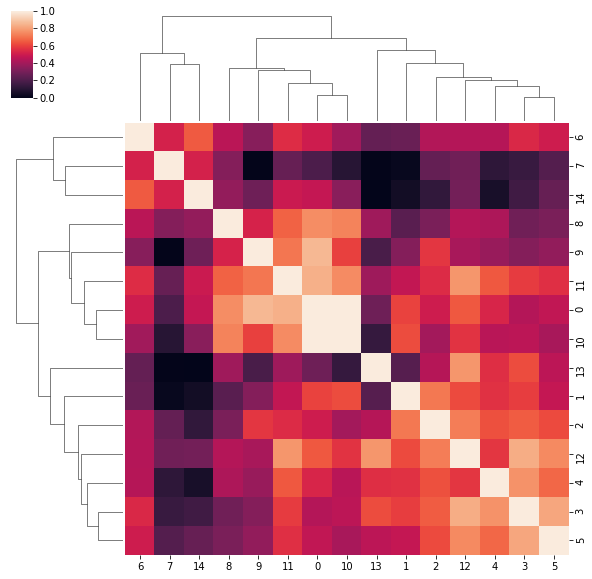

In [383]:
import seaborn as sns
sns.clustermap(stgl.similarity_matrix)

In [377]:
from regain.utils import structure_error
structure_error(np.array(thetas), stgl.precision_)

{'tp': 350,
 'tn': 1032,
 'fp': 22,
 'fn': 96,
 'precision': 0.9408602150537635,
 'recall': 0.7847533632286996,
 'f1': 0.8557457212713937,
 'accuracy': 0.9213333333333333,
 'false_omission_rate': 0.0851063829787234,
 'fdr': 0.05913978494623656,
 'npv': 0.9148936170212766,
 'prevalence': 0.29733333333333334,
 'miss_rate': 0.21524663677130046,
 'fall_out': 0.020872865275142316,
 'specificity': 0.9791271347248577,
 'plr': 37.5968202201386,
 'nlr': 0.2198352278652623,
 'dor': 171.02272727272725,
 'balanced_accuracy': 0.8819402489767787,
 'average_precision': 0.7423824549597206}

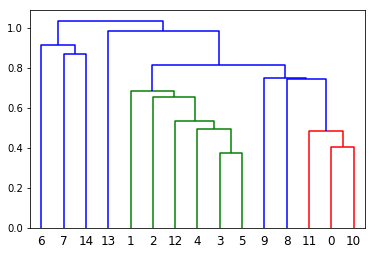

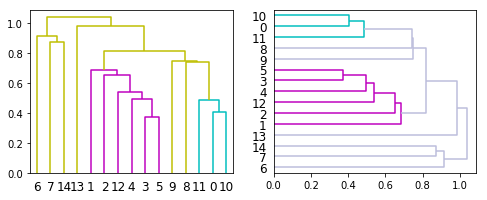

In [389]:
from scipy.cluster import hierarchy
Z = hierarchy.linkage(stgl.similarity_matrix, 'single')
plt.figure()
dn = hierarchy.dendrogram(Z)
hierarchy.set_link_color_palette(['m', 'c', 'y', 'k'])
fig, axes = plt.subplots(1, 2, figsize=(8, 3))
dn1 = hierarchy.dendrogram(Z, ax=axes[0], above_threshold_color='y',
                            orientation='top')
dn2 = hierarchy.dendrogram(Z, ax=axes[1],
                            above_threshold_color='#bcbddc',
                            orientation='right')
hierarchy.set_link_color_palette(None)  # reset to default after use
plt.show()

In [392]:
from sklearn.cluster import AgglomerativeClustering

cluster = AgglomerativeClustering(n_clusters=8, affinity='euclidean', linkage='ward')  
predicted = cluster.fit_predict(stgl.similarity_matrix) 

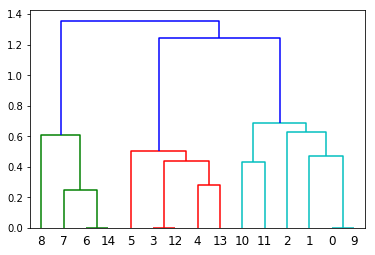

In [397]:
from scipy.cluster import hierarchy
Z = hierarchy.linkage(1-distances, 'single')
plt.figure()
dn = hierarchy.dendrogram(Z)
#hierarchy.set_link_color_palette(['m', 'c', 'y', 'k'])
# fig, axes = plt.subplots(1, 2, figsize=(8, 3))
# dn1 = hierarchy.dendrogram(Z, ax=axes[0], above_threshold_color='y',
#                             orientation='top')
# dn2 = hierarchy.dendrogram(Z, ax=axes[1],
#                             above_threshold_color='#bcbddc',
#                             orientation='right')
hierarchy.set_link_color_palette(None)  # reset to default after use
plt.show()

In [393]:
from sklearn.cluster import AgglomerativeClustering

cluster = AgglomerativeClustering(n_clusters=3, affinity='euclidean', linkage='ward')  
true = cluster.fit_predict(1-distances) 

In [394]:
from sklearn.metrics import homogeneity_completeness_v_measure
homogeneity_completeness_v_measure(predicted, true)

(0.5133746280384894, 0.9148354277124964, 0.6576809840081691)